##Phase 1 & 2 - Using Neurotoolkitv2 for all 3 questions and then training a CNN-LSTM for classification of MI vs Norm

In [ ]:
!pip install neurokit2 wfdb -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 14.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 16.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wfdb
import ast
import os
from scipy import signal
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
import neurokit2 as nk
np.random.seed(42)
tf.random.set_seed(42)

def find_data_path():
    base = '/kaggle/input/ptb-xl-dataset/'
    try:
        dirs = [d for d in os.listdir(base) if os.path.isdir(os.path.join(base, d))]
        for d in dirs:
            path = os.path.join(base, d)
            if os.path.exists(os.path.join(path, 'ptbxl_database.csv')):
                return path + '/'
    except Exception as e:
        print(f"Error: {e}")
    return None

class ECGDataLoader:
    def __init__(self):
        self.path = find_data_path()

    def load_csv(self):
        df = pd.read_csv(os.path.join(self.path, 'ptbxl_database.csv'), index_col='ecg_id')
        df.scp_codes = df.scp_codes.apply(lambda x: ast.literal_eval(x))
        return df

    def get_data(self):
        data = self.load_csv()
        normal = data[data.scp_codes.apply(lambda x: 'NORM' in x)]
        mi_types = ['IMI', 'AMI', 'ASMI', 'ILMI', 'IPLMI', 'IPMI', 'PMI', 'LMI',
                   'ALMI', 'INJAS', 'INJAL', 'INJIL', 'INJIN', 'INJLA'] #MI types included in the CSV file of the dataset #
        mi = data[data.scp_codes.apply(lambda x: any(t in x for t in mi_types))]
        print(f"Normal: {len(normal)} | MI: {len(mi)}")
        return normal, mi

    def load_ecg(self, filename):
        return wfdb.rdsamp(os.path.join(self.path, filename))[0]

2025-11-03 11:27:45.283183: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762169265.459766      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762169265.507695      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Model Architecture and Plotting

def create_model(input_shape=(1000, 12)):
    inp = keras.Input(shape=input_shape)

    x = layers.Conv1D(64, 7, padding='same')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv1D(128, 5, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.LSTM(64, return_sequences=False)(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(1, activation='sigmoid')(x)

    return Model(inputs=inp, outputs=out)

def plot_rpeak(sig, peaks, title):
    plt.figure(figsize=(15, 5))
    plt.plot(sig[:, 1], alpha=0.7, label='ECG')
    plt.scatter(peaks, sig[peaks, 1], color='red', s=100, label='R-peaks', zorder=5)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.title(title, fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()

def plot_waves(sig, labels, title):
    fig, ax = plt.subplots(figsize=(16, 5))
    ax.plot(sig, color='blue', alpha=0.6, label='ECG')

    wave_colors = {1:'green', 2:'red', 3:'orange', 4:'purple'}
    wave_names = {1:'P-wave', 2:'QRS', 3:'T-wave', 4:'R-peak'}

    for w in [1, 2, 3, 4]:
        idx = np.where(labels == w)[0]
        if len(idx) > 0:
            sz = 30 if w == 4 else 5
            mk = '*' if w == 4 else 'o'
            ax.scatter(idx, sig[idx], c=wave_colors[w], s=sz,
                      label=wave_names[w], alpha=0.5, marker=mk)

    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Amplitude')
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()

def plot_training(hist):
    def smooth(vals, factor=0.8):
        smoothed = []
        for v in vals:
            if smoothed:
                smoothed.append(smoothed[-1] * factor + v * (1 - factor))
            else:
                smoothed.append(v)
        return smoothed

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    train_acc = smooth(hist.history['accuracy'])
    val_acc = smooth(hist.history['val_accuracy'])
    axes[0].plot(train_acc, label='Train', linewidth=2)
    axes[0].plot(val_acc, label='Validation', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    train_loss = smooth(hist.history['loss'])
    val_loss = smooth(hist.history['val_loss'])
    axes[1].plot(train_loss, label='Train', linewidth=2)
    axes[1].plot(val_loss, label='Validation', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Model Loss')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()

def plot_confusion(cm, acc, auc_score):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 14},
                xticklabels=['Normal', 'MI'], yticklabels=['Normal', 'MI'])
    plt.title(f'Confusion Matrix\nAcc: {acc:.2%} | AUC: {auc_score:.3f}')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.tight_layout()

def plot_roc_curve(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, 'darkorange', lw=3, label=f'ROC (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], 'navy', lw=2, linestyle='--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()

def plot_heartbeats(norm_sig, mi_sig, norm_peaks, mi_peaks):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Heartbeat Comparison: Normal vs MI', fontsize=16, fontweight='bold')

    before, after = 50, 100

    def get_beats(sig, peaks, n=3):
        beats = []
        for pk in peaks[:n]:
            if pk > before and pk < len(sig) - after:
                beats.append(sig[pk-before:pk+after, 1])
        return beats

    norm_beats = get_beats(norm_sig, norm_peaks)
    mi_beats = get_beats(mi_sig, mi_peaks)

    for i in range(3):
        if i < len(norm_beats):
            axes[0, i].plot(norm_beats[i], color='blue', linewidth=2)
            axes[0, i].axvline(before, color='red', linestyle='--', alpha=0.5)
            axes[0, i].set_title(f'Normal Beat {i+1}')
            axes[0, i].grid(alpha=0.3)

        if i < len(mi_beats):
            axes[1, i].plot(mi_beats[i], color='red', linewidth=2)
            axes[1, i].axvline(before, color='darkred', linestyle='--', alpha=0.5)
            axes[1, i].set_title(f'MI Beat {i+1}')
            axes[1, i].grid(alpha=0.3)

    plt.tight_layout()

def plot_avg_morphology(norm_sig, mi_sig, norm_peaks, mi_peaks):
    before, after = 50, 100

    def get_avg(sig, peaks):
        beats = []
        for pk in peaks:
            if pk > before and pk < len(sig) - after:
                beats.append(sig[pk-before:pk+after, 1])
        return np.mean(beats, axis=0), np.std(beats, axis=0)

    norm_avg, norm_std = get_avg(norm_sig, norm_peaks)
    mi_avg, mi_std = get_avg(mi_sig, mi_peaks)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    time = np.arange(-before, after)

    axes[0].plot(time, norm_avg, 'b-', linewidth=2, label='Normal')
    axes[0].fill_between(time, norm_avg-norm_std, norm_avg+norm_std,
                        color='blue', alpha=0.2)
    axes[0].plot(time, mi_avg, 'r-', linewidth=2, label='MI')
    axes[0].fill_between(time, mi_avg-mi_std, mi_avg+mi_std,
                        color='red', alpha=0.2)
    axes[0].axvline(0, color='k', linestyle='--', alpha=0.5)
    axes[0].set_xlabel('Time from R-peak (samples)')
    axes[0].set_ylabel('Amplitude')
    axes[0].set_title('Average Heartbeat')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    diff = mi_avg - norm_avg
    axes[1].plot(time, diff, 'purple', linewidth=2)
    axes[1].fill_between(time, 0, diff, where=(diff > 0),
                        color='red', alpha=0.3, label='MI > Normal')
    axes[1].fill_between(time, 0, diff, where=(diff < 0),
                        color='blue', alpha=0.3, label='MI < Normal')
    axes[1].axvline(0, color='k', linestyle='--', alpha=0.5)
    axes[1].axhline(0, color='k', linestyle='-', alpha=0.3)
    axes[1].set_xlabel('Time from R-peak (samples)')
    axes[1].set_ylabel('Amplitude Difference')
    axes[1].set_title('Difference (MI - Normal)')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()

In [ ]:
# R-PEAK DETECTION - Using NeuroKit2
def find_rpeaks(sig, sampling_rate=100):
    """
    R-peak detection using NeuroKit2 professional library

    Args:
        sig: ECG signal (1D or 2D array)
        sampling_rate: Sampling frequency in Hz

    Returns:
        Array of R-peak indices
    """
    # Extract single lead if multi-lead
    if len(sig.shape) > 1:
        sig = sig[:, 1]  # Use lead II

    # Clean the signal
    ecg_cleaned = nk.ecg_clean(sig, sampling_rate=sampling_rate)

    # Detect R-peaks using NeuroKit2's robust algorithm
    _, peaks_dict = nk.ecg_peaks(ecg_cleaned, sampling_rate=sampling_rate,
                                  method='neurokit')

    r_peaks = peaks_dict['ECG_R_Peaks']

    return r_peaks


#####################################
# WAVE ANNOTATION
def label_waves(sig, peaks, fs=100):
    """ Label ECG waves using NeuroKit2's delineation method. Returns labels:
        0 = background
        1 = P-wave
        2 = QRS complex
        3 = T-wave
        4 = R-peak
    """
    if len(sig.shape) > 1:
        sig = sig[:, 1] #Lead II

    wave_labels = np.zeros(len(sig))

    try:
        # Clean signal
        ecg_cleaned = nk.ecg_clean(sig, sampling_rate=fs)

        # Get delineation
        _, waves = nk.ecg_delineate(ecg_cleaned, peaks, sampling_rate=fs,
                                     method='dwt')  # Discrete Wavelet Transform

        # Label P-waves
        if 'ECG_P_Peaks' in waves and waves['ECG_P_Peaks'] is not None:
            p_peaks = waves['ECG_P_Peaks']
            p_peaks = p_peaks[~np.isnan(p_peaks)].astype(int)
            for p in p_peaks:
                start = max(0, p - int(0.04 * fs))
                end = min(len(sig), p + int(0.04 * fs))
                wave_labels[start:end] = 1

        # Label QRS complexes (Q, R, S)
        if 'ECG_R_Onsets' in waves and waves['ECG_R_Offsets'] in waves:
            q_onsets = waves['ECG_R_Onsets']
            s_offsets = waves['ECG_R_Offsets']

            if q_onsets is not None and s_offsets is not None:
                q_onsets = q_onsets[~np.isnan(q_onsets)].astype(int)
                s_offsets = s_offsets[~np.isnan(s_offsets)].astype(int)

                for q, s in zip(q_onsets, s_offsets):
                    if 0 <= q < len(sig) and 0 <= s < len(sig):
                        wave_labels[q:s] = 2

        # Label T-waves
        if 'ECG_T_Peaks' in waves and waves['ECG_T_Peaks'] is not None:
            t_peaks = waves['ECG_T_Peaks']
            t_peaks = t_peaks[~np.isnan(t_peaks)].astype(int)
            for t in t_peaks:
                start = max(0, t - int(0.06 * fs))
                end = min(len(sig), t + int(0.06 * fs))
                wave_labels[start:end] = 3

        # Mark R-peaks (override other labels)
        for r in peaks:
            start = max(0, r - 2)
            end = min(len(sig), r + 3)
            wave_labels[start:end] = 4

    except Exception as e:
        print(f"  Warning: NeuroKit2 delineation failed, using fallback method")
        # Fallback to simple rule-based annotation
        for pk in peaks:
            # P-wave: 240ms to 80ms before R-peak
            p_start = max(0, pk - int(0.24 * fs))
            p_end = max(0, pk - int(0.08 * fs))
            wave_labels[p_start:p_end] = 1

            # QRS complex: 40ms before to 80ms after R-peak
            qrs_start = max(0, pk - int(0.04 * fs))
            qrs_end = min(len(sig), pk + int(0.08 * fs))
            wave_labels[qrs_start:qrs_end] = 2

            # T-wave: 100ms to 400ms after R-peak
            t_start = min(len(sig), pk + int(0.10 * fs))
            t_end = min(len(sig), pk + int(0.40 * fs))
            wave_labels[t_start:t_end] = 3

            # R-peak itself
            r_start = max(0, pk - 2)
            r_end = min(len(sig), pk + 3)
            wave_labels[r_start:r_end] = 4

    return wave_labels



# DATA LOADING
def load_all_data(loader, df_norm, df_mi, max_samples=None, verbose=True):
    """
    Load all ECG data for training

    Args:
        loader: ECGDataLoader instance
        df_norm: DataFrame with normal ECGs
        df_mi: DataFrame with MI ECGs
        max_samples: Maximum samples per class (None = all)
        verbose: Print progress

    Returns:
        X: ECG signals array
        y: Labels array (0=normal, 1=MI)
    """
    signals = []
    labels = []

    # Sample if requested
    if max_samples:
        df_norm = df_norm.sample(min(max_samples, len(df_norm)))
        df_mi = df_mi.sample(min(max_samples, len(df_mi)))

    if verbose:
        print(f"Loading {len(df_norm)} normal ECGs...")

    failed_count = 0
    for idx in df_norm.index:
        try:
            ecg = loader.load_ecg(df_norm.loc[idx, 'filename_lr'])
            if ecg.shape == (1000, 12):  # Verify correct shape
                signals.append(ecg)
                labels.append(0)
        except Exception as e:
            failed_count += 1
            if verbose and failed_count % 100 == 0:
                print(f"  Skipped {failed_count} files due to errors")
            continue

    if verbose:
        print(f"  ✓ Loaded {len([l for l in labels if l == 0])} normal ECGs")
        print(f"Loading {len(df_mi)} MI ECGs...")

    failed_count = 0
    for idx in df_mi.index:
        try:
            ecg = loader.load_ecg(df_mi.loc[idx, 'filename_lr'])
            if ecg.shape == (1000, 12):
                signals.append(ecg)
                labels.append(1)
        except Exception as e:
            failed_count += 1
            if verbose and failed_count % 100 == 0:
                print(f"  Skipped {failed_count} files due to errors")
            continue

    signals = np.array(signals)
    labels = np.array(labels)

    if verbose:
        print(f"  ✓ Loaded {np.sum(labels==1)} MI ECGs")
        print(f"\n{'='*70}")
        print(f"TOTAL DATASET:")
        print(f"  Total: {len(signals)} ECGs")
        print(f"  Normal: {np.sum(labels==0)} ({100*np.sum(labels==0)/len(labels):.1f}%)")
        print(f"  MI: {np.sum(labels==1)} ({100*np.sum(labels==1)/len(labels):.1f}%)")
        print(f"{'='*70}")

    return signals, labels


Normal: 9528 | MI: 5486

 R-peak detection
Normal: 16 peaks | MI: 11 peaks


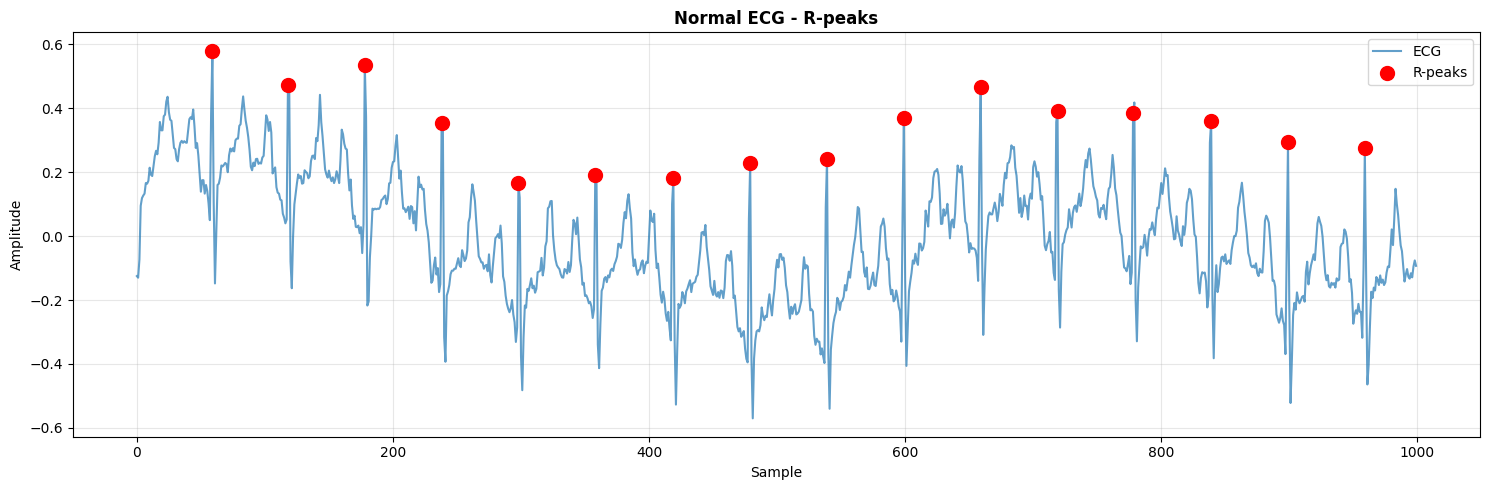

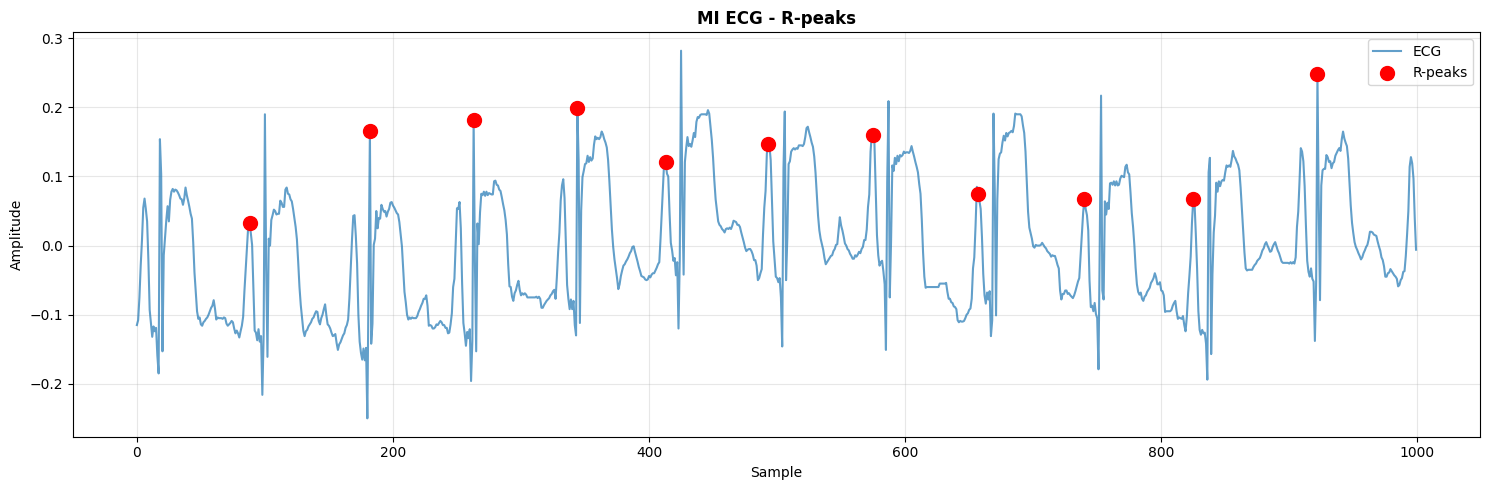


 Morphology Annotation


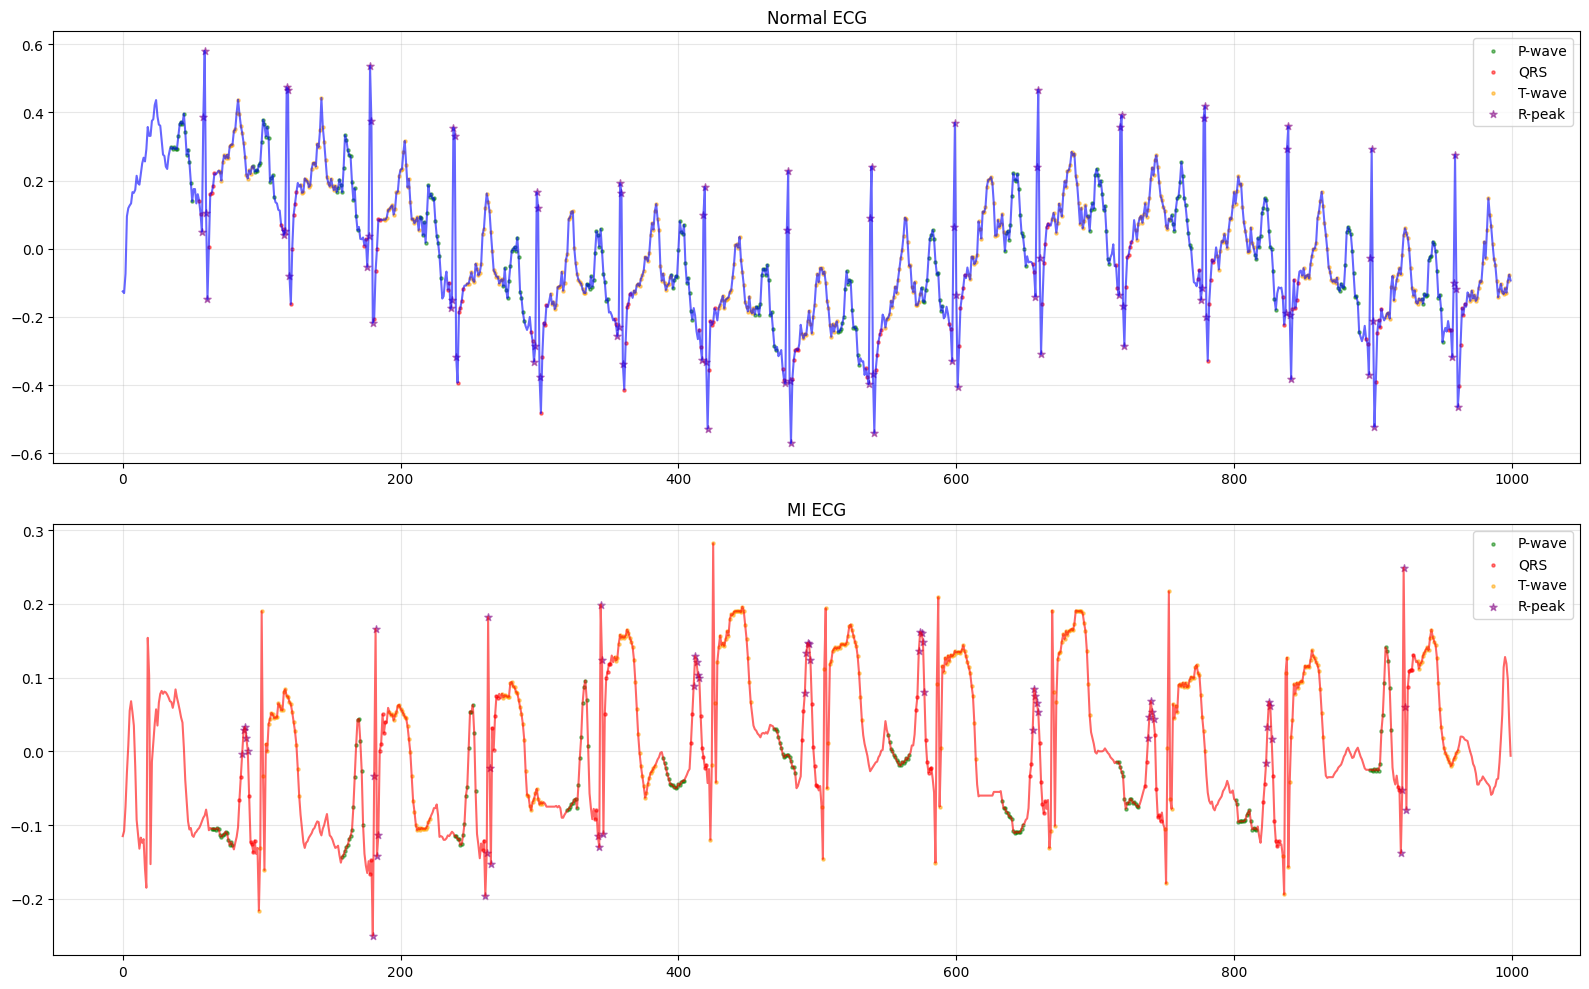


 Morphology Comparison


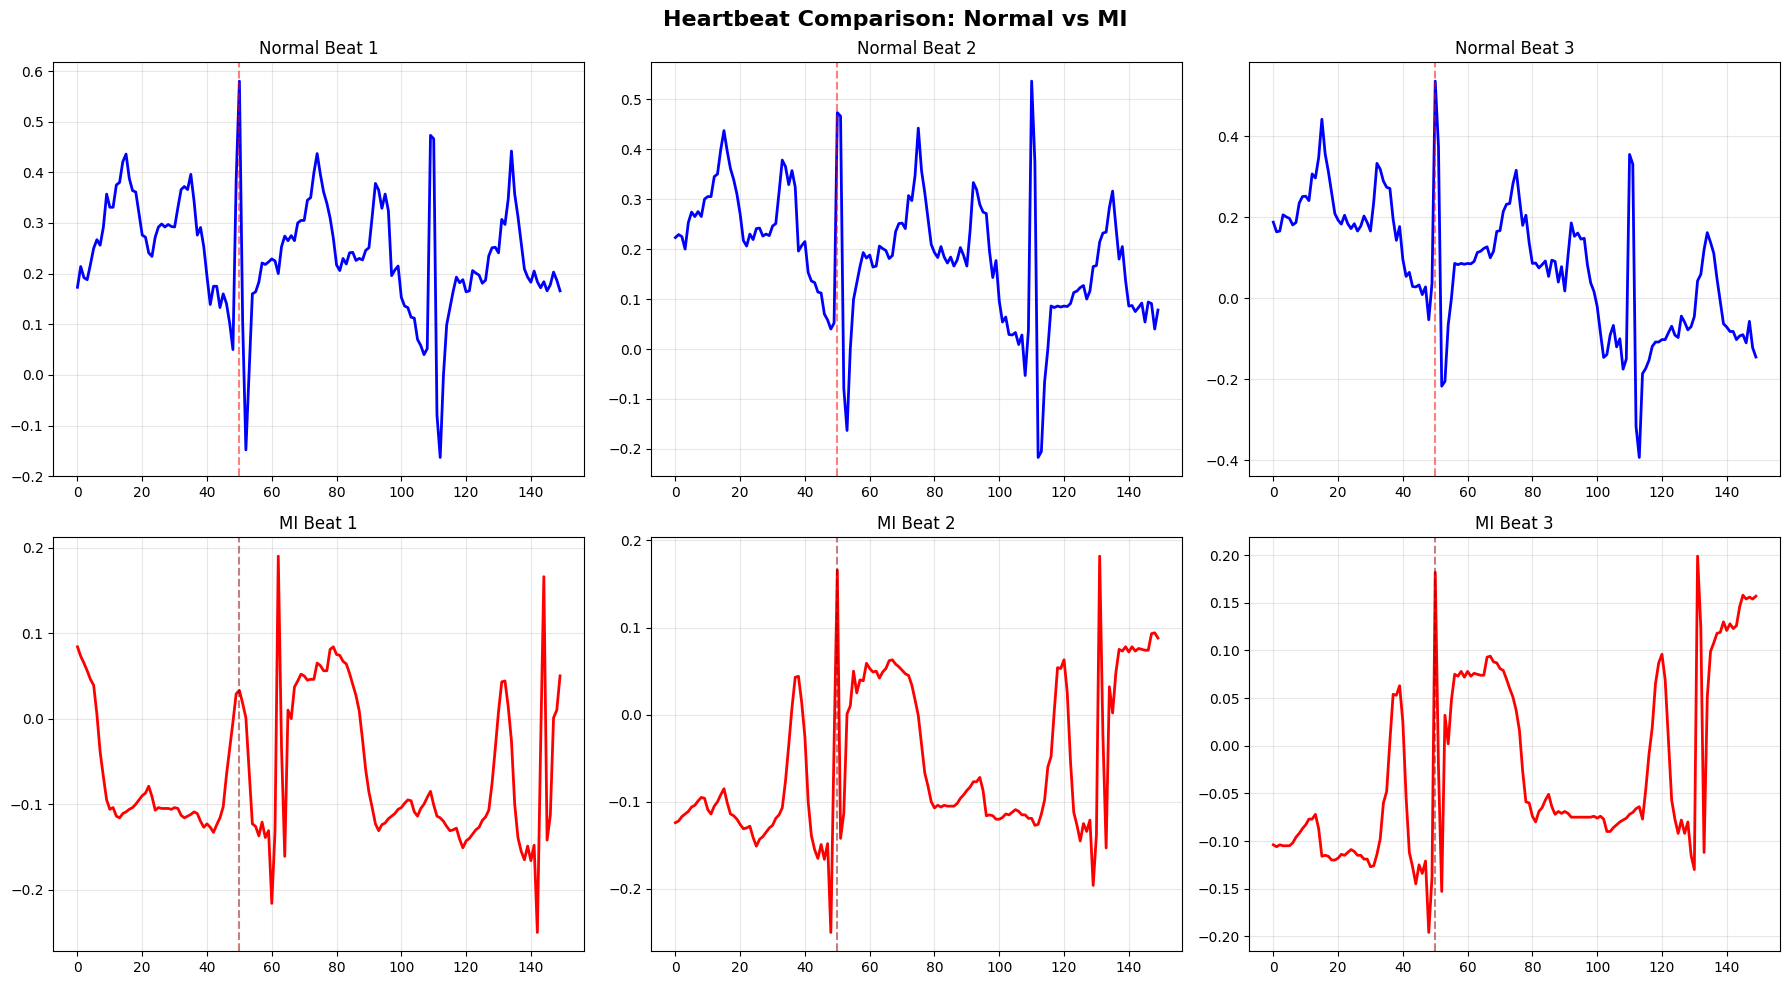

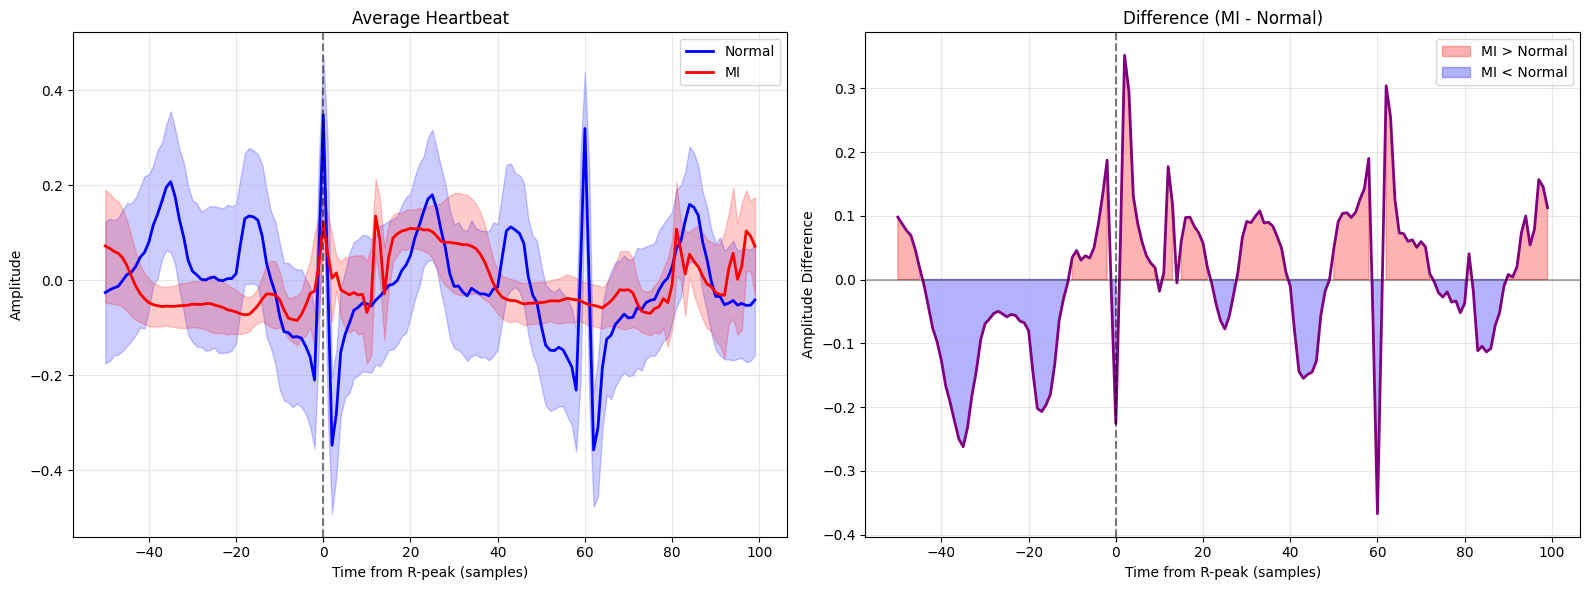


 Classification Model for Norm vs MI
Loading 9528 normal ECGs...
  ✓ Loaded 9528 normal ECGs
Loading 5486 MI ECGs...
  ✓ Loaded 5486 MI ECGs

TOTAL DATASET:
  Total: 15014 ECGs
  Normal: 9528 (63.5%)
  MI: 5486 (36.5%)
Train: 12011 | Val: 3003


I0000 00:00:1762169519.989510      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762169519.990252      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Training...
Epoch 1/100


I0000 00:00:1762169527.379094     120 cuda_dnn.cc:529] Loaded cuDNN version 90300


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6416 - loss: 0.6394
Epoch 1: val_accuracy improved from -inf to 0.71162, saving model to best_model.h5
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.6424 - loss: 0.6388 - val_accuracy: 0.7116 - val_loss: 0.7499 - learning_rate: 0.0010
Epoch 2/100
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7995 - loss: 0.4822
Epoch 2: val_accuracy improved from 0.71162 to 0.78688, saving model to best_model.h5
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.7995 - loss: 0.4818 - val_accuracy: 0.7869 - val_loss: 0.5350 - learning_rate: 0.0010
Epoch 3/100
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8264 - loss: 0.4194
Epoch 3: val_accuracy improved from 0.78688 to 0.84482, saving model to best_model.h5
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8265 - loss: 0.4196 - val_accuracy: 0.8448 - val_loss: 0.3655 - learning_rate: 0.0010
Epoch 4/100
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8489 - loss:

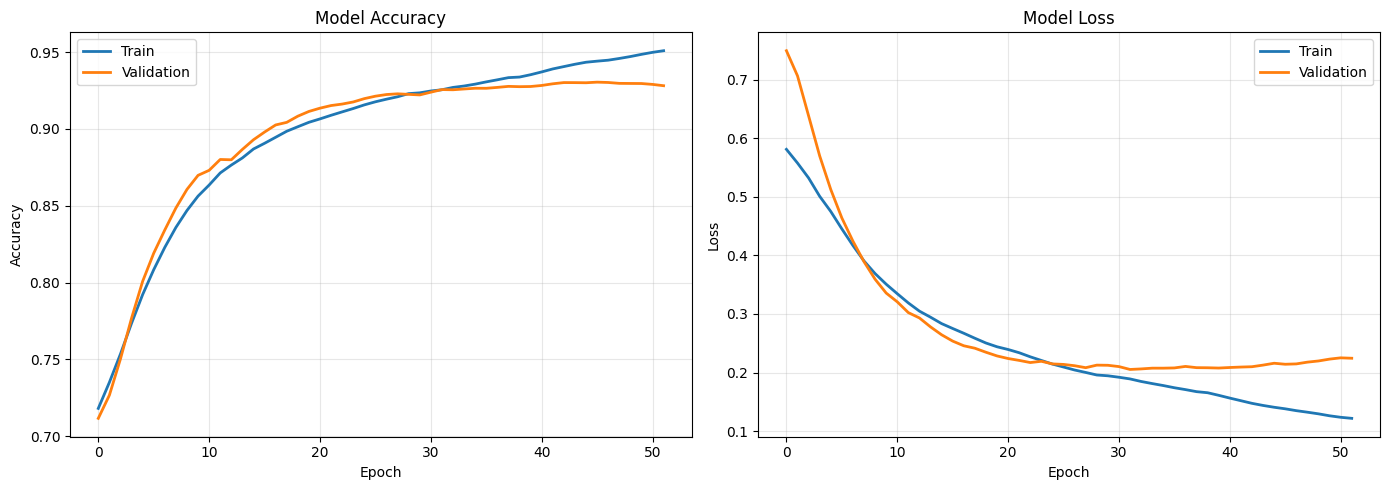

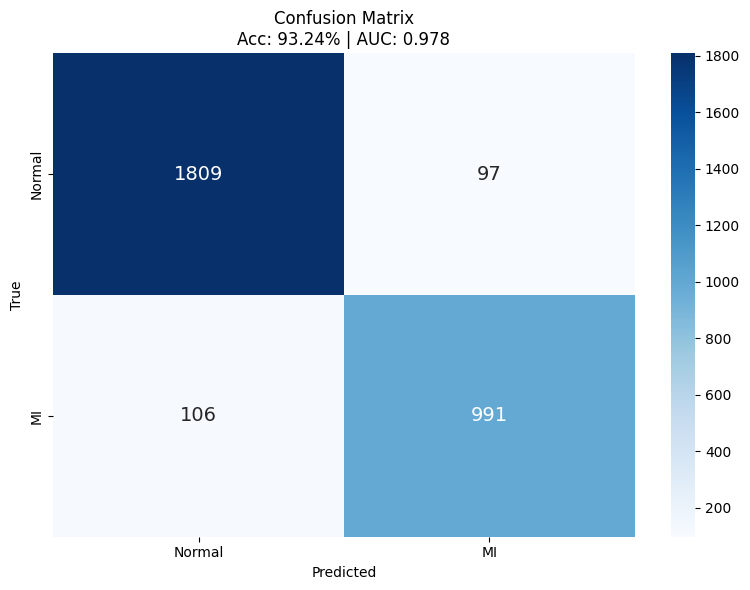

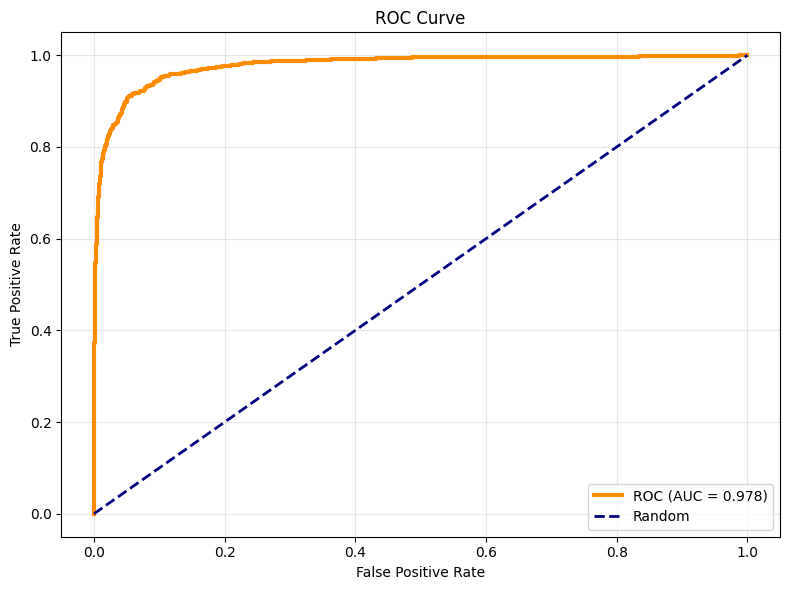

In [ ]:
# Main Analysis
loader = ECGDataLoader()
df_normal, df_mi = loader.get_data()

# R-peak detection
print("\n R-peak detection")
norm_ecg = loader.load_ecg(df_normal.sample(1).iloc[0]['filename_lr'])
mi_ecg = loader.load_ecg(df_mi.sample(1).iloc[0]['filename_lr'])

norm_rpeaks = find_rpeaks(norm_ecg[:, 1])
mi_rpeaks = find_rpeaks(mi_ecg[:, 1])

print(f"Normal: {len(norm_rpeaks)} peaks | MI: {len(mi_rpeaks)} peaks")

plot_rpeak(norm_ecg, norm_rpeaks, "Normal ECG - R-peaks")
plt.savefig('/kaggle/working/rpeak_normal.png', dpi=150, bbox_inches='tight')
plt.show()

plot_rpeak(mi_ecg, mi_rpeaks, "MI ECG - R-peaks")
plt.savefig('/kaggle/working/rpeak_mi.png', dpi=150, bbox_inches='tight')
plt.show()

# Wave annotation
print("\n Morphology Annotation")
norm_waves = label_waves(norm_ecg[:, 1], norm_rpeaks)
mi_waves = label_waves(mi_ecg[:, 1], mi_rpeaks)

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

for ax, ecg, waves, name in [(axes[0], norm_ecg, norm_waves, 'Normal'),
                              (axes[1], mi_ecg, mi_waves, 'MI')]:
    ax.plot(ecg[:, 1], color='blue' if name=='Normal' else 'red', alpha=0.6)
    colors = {1:'green', 2:'red', 3:'orange', 4:'purple'}
    names = {1:'P-wave', 2:'QRS', 3:'T-wave', 4:'R-peak'}

    for w in [1, 2, 3, 4]:
        idx = np.where(waves == w)[0]
        if len(idx) > 0:
            sz = 30 if w == 4 else 5
            mk = '*' if w == 4 else 'o'
            ax.scatter(idx, ecg[idx, 1], c=colors[w], s=sz,
                      label=names[w], alpha=0.5, marker=mk)

    ax.set_title(f'{name} ECG')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/kaggle/working/morphology.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Morphology Comparison")
plot_heartbeats(norm_ecg, mi_ecg, norm_rpeaks, mi_rpeaks)
plt.savefig('/kaggle/working/heartbeat_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

plot_avg_morphology(norm_ecg, mi_ecg, norm_rpeaks, mi_rpeaks)
plt.savefig('/kaggle/working/avg_morphology.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Classification Model for Norm vs MI")
X, y = load_all_data(loader, df_normal, df_mi)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {len(X_train)} | Val: {len(X_val)}")

model = create_model()
model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

callbacks_list = [
    ModelCheckpoint('best_model.h5', monitor='val_accuracy',
                   save_best_only=True, mode='max', verbose=1),
    EarlyStopping(monitor='val_loss', patience=20,
                 restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7,
                     min_lr=1e-6, verbose=1)
]

print("Training...")
hist = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=128,
    class_weight=class_weights,
    callbacks=callbacks_list,
    verbose=1
)

# Results
y_pred_prob = model.predict(X_val, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

print("\n" + "="*80)
print("Results")
print("="*80)
print(classification_report(y_val, y_pred, target_names=['Normal', 'MI']))

cm = confusion_matrix(y_val, y_pred)
acc = accuracy_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred_prob)

tn, fp, fn, tp = cm.ravel()
sens = tp / (tp + fn)
spec = tn / (tn + fp)

print(f"\nAccuracy: {acc:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Sensitivity: {sens:.4f}")
print(f"Specificity: {spec:.4f}")

plot_training(hist)
plt.savefig('/kaggle/working/training.png', dpi=150, bbox_inches='tight')
plt.show()

plot_confusion(cm, acc, auc)
plt.savefig('/kaggle/working/confusion.png', dpi=150, bbox_inches='tight')
plt.show()

plot_roc_curve(y_val, y_pred_prob)
plt.savefig('/kaggle/working/roc.png', dpi=150, bbox_inches='tight')
plt.show()


##Phase 3 - Training a CNN model to detect R peaks based on Neurottolkit r peak detection mask

ecg pipeline (cnn r-peak) – run
normal=9528 | mi=5486

--- build r-peak dataset ---
making set from 9528 rows...
  500 done
  1000 done
  1500 done
  2000 done
  2500 done
  3000 done
  3500 done
  4000 done
  4500 done
  5000 done
  5500 done
  6000 done
  6500 done
  7000 done
  7500 done
  8000 done
  8500 done
  9000 done
  9500 done
dataset: 9528 signals x 1000 samples | r% ~ 5.69
making set from 5486 rows...
  500 done
  1000 done
  1500 done
  2000 done
  2500 done
  3000 done
  3500 done
  4000 done
  4500 done
  5000 done
dataset: 5481 signals x 1000 samples | r% ~ 6.07
total signals: 15009

--- train ---
Epoch 1/100


I0000 00:00:1762169872.117322     119 service.cc:148] XLA service 0x7fa3f4076a10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762169872.118390     119 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762169872.118409     119 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2025-11-03 11:37:55.398610: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{k11=2} for conv (f32[32,128,1,250]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,1,250]{3,2,1,0}, f32[128,128,1,7]{3,2,1,0}), window={size=1x7 pad=0_0x3_3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-11-03 11:

  3/376 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.1039 - dice: 0.1059 - loss: 1.3086  

I0000 00:00:1762169883.455858     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


376/376 ━━━━━━━━━━━━━━━━━━━━ 48s 78ms/step - accuracy: 0.8901 - dice: 0.6423 - loss: 0.3146 - val_accuracy: 0.9849 - val_dice: 0.8548 - val_loss: 0.0534
Epoch 2/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.9888 - dice: 0.8878 - loss: 0.0490 - val_accuracy: 0.9866 - val_dice: 0.8692 - val_loss: 0.0456
Epoch 3/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9908 - dice: 0.9070 - loss: 0.0396 - val_accuracy: 0.9880 - val_dice: 0.8874 - val_loss: 0.0380
Epoch 4/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9917 - dice: 0.9168 - loss: 0.0349 - val_accuracy: 0.9898 - val_dice: 0.9044 - val_loss: 0.0318
Epoch 5/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9928 - dice: 0.9299 - loss: 0.0290 - val_accuracy: 0.9886 - val_dice: 0.8942 - val_loss: 0.0349
Epoch 6/100
376/376 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9930 - dice: 0.9322 - loss: 0.0278 - val_accuracy: 0.9906 - val_dice: 0.9131 - val_loss: 0.0289
Epoch 7/100
376/376 ━━

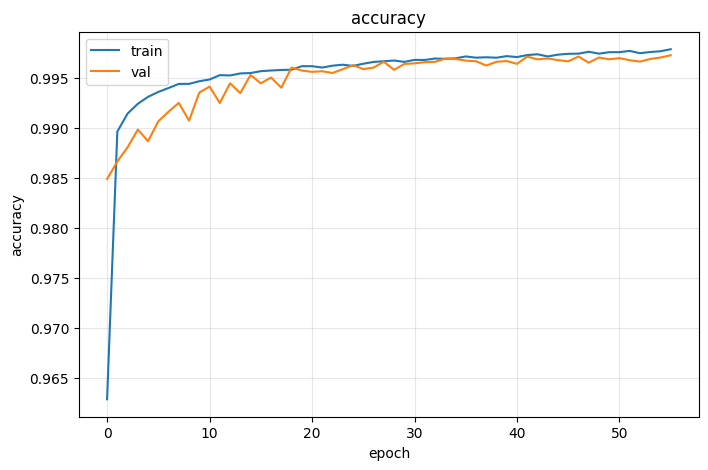

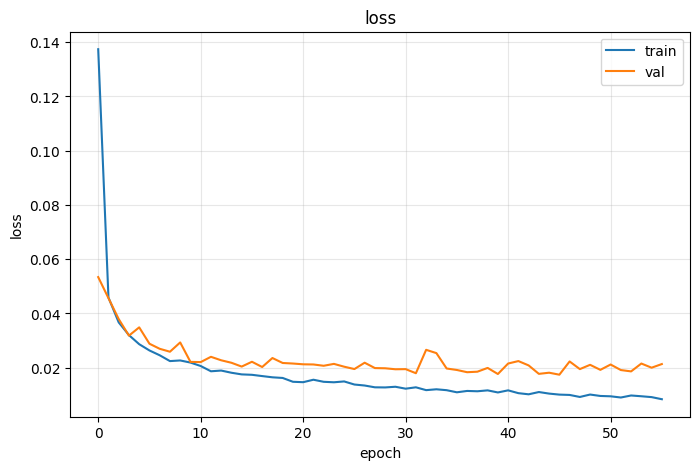

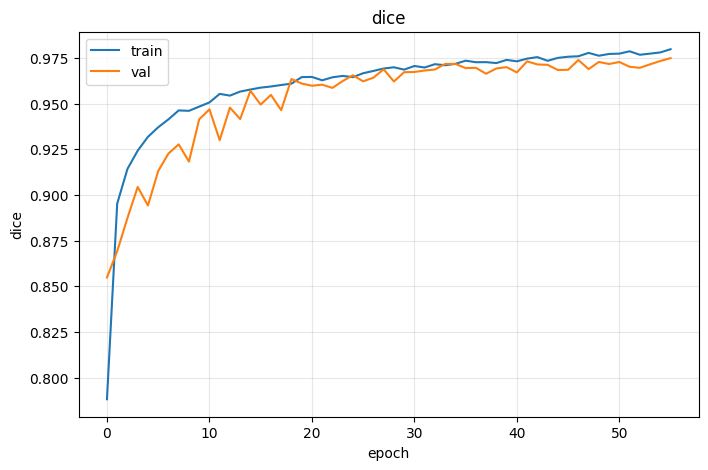


--- sample inference + basic counts ---
normal: nk=16 | cnn=16
mi    : nk=11   | cnn=11

labels summary (counts per class) – normal:
{0: 132, 1: 256, 2: 112, 3: 420, 4: 80}
labels summary (counts per class) – mi:
{0: 362, 1: 176, 2: 77, 3: 330, 4: 55}

DONE.


In [ ]:
import numpy as np
import pandas as pd
import wfdb
import ast
import os
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import neurokit2 as nk
import matplotlib.pyplot as plt  # for curves

np.random.seed(42)
tf.random.set_seed(42)

# data utils
def _find_data_root():
    base = '/kaggle/input/ptb-xl-dataset/'
    try:
        dirs = [d for d in os.listdir(base) if os.path.isdir(os.path.join(base, d))]
        for d in dirs:
            path = os.path.join(base, d)
            if os.path.exists(os.path.join(path, 'ptbxl_database.csv')):
                return path + '/'
    except Exception as e:
        print(f"path error: {e}")
    return None

class ECGLoader:
    def __init__(self):
        self.root = _find_data_root()
    def _csv(self):
        df = pd.read_csv(os.path.join(self.root, 'ptbxl_database.csv'), index_col='ecg_id')
        df.scp_codes = df.scp_codes.apply(lambda x: ast.literal_eval(x))
        return df
    def split_norm_mi(self):
        df = self._csv()
        norm = df[df.scp_codes.apply(lambda x: 'NORM' in x)]
        mi_tags = ['IMI','AMI','ASMI','ILMI','IPLMI','IPMI','PMI','LMI','ALMI','INJAS','INJAL','INJIL','INJIN','INJLA']
        mi = df[df.scp_codes.apply(lambda x: any(t in x for t in mi_tags))]
        print(f"normal={len(norm)} | mi={len(mi)}")
        return norm, mi
    def read_ecg(self, relpath):
        return wfdb.rdsamp(os.path.join(self.root, relpath))[0]

# r-peak dataset
def _make_r_labels(sig, r_idx, w=5):
    lab = np.zeros(len(sig))
    for r in r_idx:
        s = max(0, r - w // 2)
        e = min(len(sig), r + w // 2 + 1)
        lab[s:e] = 1
    return lab

def build_rpeak_set(loader, df, max_samples=None, fs=100, verbose=True):
    X, Y, R = [], [], []
    if max_samples:
        df = df.sample(min(max_samples, len(df)))
    if verbose:
        print(f"making set from {len(df)} rows...")
    for _, row in df.iterrows():
        try:
            ecg = loader.read_ecg(row['filename_lr'])
            lead2 = ecg[:, 1] if len(ecg.shape) > 1 else ecg
            clean = nk.ecg_clean(lead2, sampling_rate=fs)
            _, pkd = nk.ecg_peaks(clean, sampling_rate=fs, method='neurokit')
            r = pkd['ECG_R_Peaks']
            if len(r) == 0:
                continue
            y = _make_r_labels(clean, r, w=5)
            X.append(clean); Y.append(y); R.append(r)
            if verbose and len(X) % 500 == 0:
                print(f"  {len(X)} done")
        except:
            continue
    X = np.array(X); Y = np.array(Y)
    if verbose:
        p = 100*Y.mean()
        print(f"dataset: {len(X)} signals x {X.shape[1]} samples | r% ~ {p:.2f}")
    return X, Y, R

# -----------------------------
# cnn for r-peak mask
# -----------------------------
def build_cnn(input_len=1000):
    inp = keras.Input(shape=(input_len, 1))
    c1 = layers.Conv1D(32, 15, padding='same', activation='relu')(inp)
    c1 = layers.Conv1D(32, 15, padding='same', activation='relu')(c1)
    p1 = layers.MaxPooling1D(2)(c1); p1 = layers.Dropout(0.2)(p1)
    c2 = layers.Conv1D(64, 11, padding='same', activation='relu')(p1)
    c2 = layers.Conv1D(64, 11, padding='same', activation='relu')(c2)
    p2 = layers.MaxPooling1D(2)(c2); p2 = layers.Dropout(0.2)(p2)
    c3 = layers.Conv1D(128, 7, padding='same', activation='relu')(p2)
    c3 = layers.Conv1D(128, 7, padding='same', activation='relu')(c3)
    p3 = layers.MaxPooling1D(2)(c3); p3 = layers.Dropout(0.3)(p3)
    b  = layers.Conv1D(256, 5, padding='same', activation='relu')(p3)
    b  = layers.Conv1D(256, 5, padding='same', activation='relu')(b)
    b  = layers.Dropout(0.3)(b)
    u1 = layers.UpSampling1D(2)(b);  u1 = layers.Concatenate()([u1, c3])
    c4 = layers.Conv1D(128, 7, padding='same', activation='relu')(u1)
    c4 = layers.Conv1D(128, 7, padding='same', activation='relu')(c4)
    c4 = layers.Dropout(0.2)(c4)
    u2 = layers.UpSampling1D(2)(c4); u2 = layers.Concatenate()([u2, c2])
    c5 = layers.Conv1D(64, 11, padding='same', activation='relu')(u2)
    c5 = layers.Conv1D(64, 11, padding='same', activation='relu')(c5)
    c5 = layers.Dropout(0.2)(c5)
    u3 = layers.UpSampling1D(2)(c5); u3 = layers.Concatenate()([u3, c1])
    c6 = layers.Conv1D(32, 15, padding='same', activation='relu')(u3)
    c6 = layers.Conv1D(32, 15, padding='same', activation='relu')(c6)
    out = layers.Conv1D(1, 1, activation='sigmoid')(c6)
    return Model(inputs=inp, outputs=out, name='rpeak_cnn')

def weighted_bce(pos_w=10.0):
    def _loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)
        lp = -pos_w * y_true * tf.math.log(y_pred)
        ln = -(1 - y_true) * tf.math.log(1 - y_pred)
        return tf.reduce_mean(lp + ln)
    return _loss

def dice(y_true, y_pred, eps=1e-6):
    yt = tf.reshape(y_true, [-1])
    yp = tf.reshape(y_pred, [-1])
    inter = tf.reduce_sum(yt * yp)
    return (2.*inter + eps) / (tf.reduce_sum(yt) + tf.reduce_sum(yp) + eps)

def pick_peaks_from_mask(mask, thr=0.5, min_dist=50):
    b = (mask > thr).astype(int).flatten()
    peaks, i = [], 0
    while i < len(b):
        if b[i] == 1:
            s = i
            while i < len(b) and b[i] == 1:
                i += 1
            e = i
            peaks.append((s+e)//2)
            i = e + min_dist
        else:
            i += 1
    return np.array(peaks)

# -----------------------------
# wave labels via neurokit
def annotate_waves(sig, r_idx, fs=100):
    if len(sig.shape) > 1:
        sig = sig[:, 1]
    lab = np.zeros(len(sig))
    try:
        clean = nk.ecg_clean(sig, sampling_rate=fs)
        _, w = nk.ecg_delineate(clean, r_idx, sampling_rate=fs, method='dwt')
        if 'ECG_P_Peaks' in w and w['ECG_P_Peaks'] is not None:
            p = w['ECG_P_Peaks']; p = p[~np.isnan(p)].astype(int)
            for k in p:
                s = max(0, k - int(0.04*fs)); e = min(len(sig), k + int(0.04*fs))
                lab[s:e] = 1
        if 'ECG_R_Onsets' in w and 'ECG_R_Offsets' in w:
            q = w['ECG_R_Onsets']; s = w['ECG_R_Offsets']
            if q is not None and s is not None:
                q = q[~np.isnan(q)].astype(int); s = s[~np.isnan(s)].astype(int)
                for a, b in zip(q, s):
                    if 0 <= a < len(sig) and 0 <= b < len(sig):
                        lab[a:b] = 2
        if 'ECG_T_Peaks' in w and w['ECG_T_Peaks'] is not None:
            t = w['ECG_T_Peaks']; t = t[~np.isnan(t)].astype(int)
            for k in t:
                a = max(0, k - int(0.06*fs)); b = min(len(sig), k + int(0.06*fs))
                lab[a:b] = 3
        for r in r_idx:
            a = max(0, r - 2); b = min(len(sig), r + 3)
            lab[a:b] = 4
    except:
        for r in r_idx:
            p1 = max(0, r - int(0.24*fs)); p2 = max(0, r - int(0.08*fs)); lab[p1:p2] = 1
            q1 = max(0, r - int(0.04*fs)); q2 = min(len(sig), r + int(0.08*fs)); lab[q1:q2] = 2
            t1 = min(len(sig), r + int(0.10*fs)); t2 = min(len(sig), r + int(0.40*fs)); lab[t1:t2] = 3
            a = max(0, r - 2); b = min(len(sig), r + 3); lab[a:b] = 4
    return lab



# run
print("="*80)
print("ecg pipeline (cnn r-peak) – run")
print("="*80)

USE_ALL = True
MAX_SAMPLES = None if USE_ALL else 1500
loader = ECGLoader()
df_norm, df_mi = loader.split_norm_mi()

print("\n--- build r-peak dataset ---")
Xn, Yn, _ = build_rpeak_set(loader, df_norm, max_samples=MAX_SAMPLES)
Xm, Ym, _ = build_rpeak_set(loader, df_mi,   max_samples=MAX_SAMPLES)

X = np.concatenate([Xn, Xm], axis=0)
Y = np.concatenate([Yn, Ym], axis=0)

X = X.reshape(-1, X.shape[1], 1)
Y = Y.reshape(-1, Y.shape[1], 1)

print(f"total signals: {X.shape[0]}")

X_tr, X_va, Y_tr, Y_va = train_test_split(X, Y, test_size=0.2, random_state=42)

net = build_cnn(input_len=X.shape[1])
pos_w = (Y_tr == 0).sum() / (Y_tr == 1).sum()

net.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=weighted_bce(pos_w),
    metrics=['accuracy', dice]
)

print("\n--- train ---")
hist = net.fit(
    X_tr, Y_tr,
    validation_data=(X_va, Y_va),
    epochs=100,
    batch_size=32,
    callbacks=[
        ModelCheckpoint('rpeak_cnn.h5', monitor='val_dice', save_best_only=True, mode='max', verbose=0),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
    ],
    verbose=1
)

print("\ntraining done.")
print(f"best val dice: {max(hist.history['val_dice']):.4f}")

#training curves
#accuracy
plt.figure(figsize=(8,5))
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='val')
plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.title('accuracy'); plt.legend(); plt.grid(alpha=0.3)
plt.savefig('/kaggle/working/train_acc.png', dpi=150, bbox_inches='tight'); plt.show()

# loss
plt.figure(figsize=(8,5))
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.title('loss'); plt.legend(); plt.grid(alpha=0.3)
plt.savefig('/kaggle/working/train_loss.png', dpi=150, bbox_inches='tight'); plt.show()

# dice
plt.figure(figsize=(8,5))
plt.plot(hist.history['dice'], label='train')
plt.plot(hist.history['val_dice'], label='val')
plt.xlabel('epoch'); plt.ylabel('dice'); plt.title('dice'); plt.legend(); plt.grid(alpha=0.3)
plt.savefig('/kaggle/working/train_dice.png', dpi=150, bbox_inches='tight'); plt.show()

# reload best model for inference
net = keras.models.load_model(
    'rpeak_cnn.h5',
    custom_objects={'dice': dice, 'loss': weighted_bce(pos_w)},
    compile=False
)

print("\n--- sample inference + basic counts ---")
ex_norm = loader.read_ecg(df_norm.sample(1).iloc[0]['filename_lr'])
ex_mi   = loader.read_ecg(df_mi.sample(1).iloc[0]['filename_lr'])

lead_norm = ex_norm[:, 1]
lead_mi   = ex_mi[:, 1]

clean_norm = nk.ecg_clean(lead_norm, sampling_rate=100)
clean_mi   = nk.ecg_clean(lead_mi,   sampling_rate=100)

#neurokit baseline peaks
_, nk_norm = nk.ecg_peaks(clean_norm, sampling_rate=100, method='neurokit')
_, nk_mi   = nk.ecg_peaks(clean_mi,   sampling_rate=100, method='neurokit')
nk_r_norm = nk_norm['ECG_R_Peaks']
nk_r_mi   = nk_mi['ECG_R_Peaks']

# cnn mask -> r-peaks
pred_norm = net.predict(clean_norm.reshape(1, -1, 1), verbose=0)[0]
pred_mi   = net.predict(clean_mi.reshape(1, -1, 1),   verbose=0)[0]
r_cnn_norm = pick_peaks_from_mask(pred_norm, thr=0.5, min_dist=50)
r_cnn_mi   = pick_peaks_from_mask(pred_mi,   thr=0.5, min_dist=50)

print(f"normal: nk={len(nk_r_norm)} | cnn={len(r_cnn_norm)}")
print(f"mi    : nk={len(nk_r_mi)}   | cnn={len(r_cnn_mi)}")

# wave labels using cnn peaks
lab_norm = annotate_waves(lead_norm, r_cnn_norm)
lab_mi   = annotate_waves(lead_mi,   r_cnn_mi)

print("\nlabels summary (counts per class) – normal:")
uniq, cnt = np.unique(lab_norm, return_counts=True)
print(dict(zip(uniq.astype(int), cnt.tolist())))

print("labels summary (counts per class) – mi:")
uniq, cnt = np.unique(lab_mi, return_counts=True)
print(dict(zip(uniq.astype(int), cnt.tolist())))

print("\nDONE.")


model loaded
normal: records100/07000/07078_lr | nk: 12 cnn: 11
mi    : records100/07000/07813_lr | nk: 12 cnn: 12


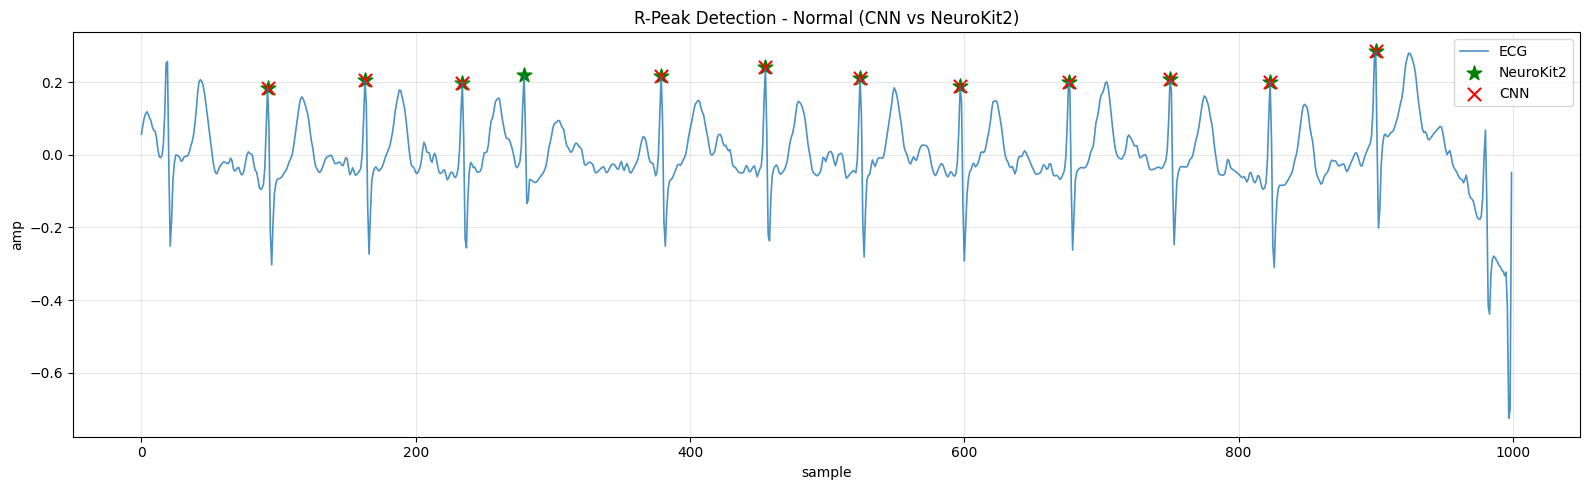

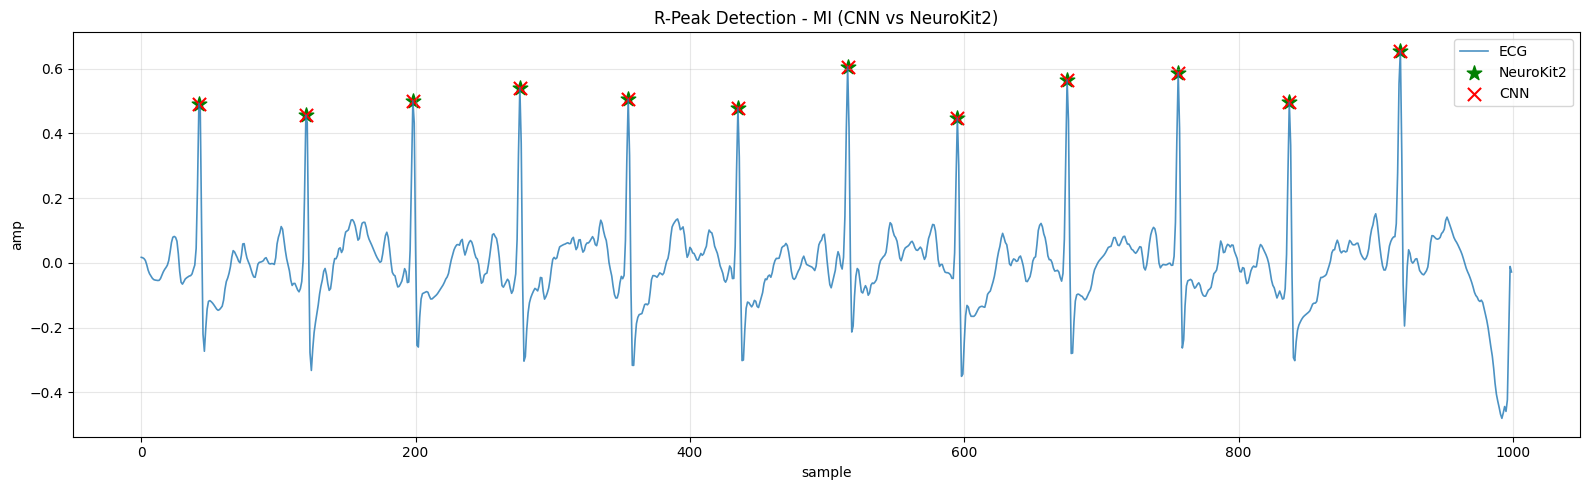

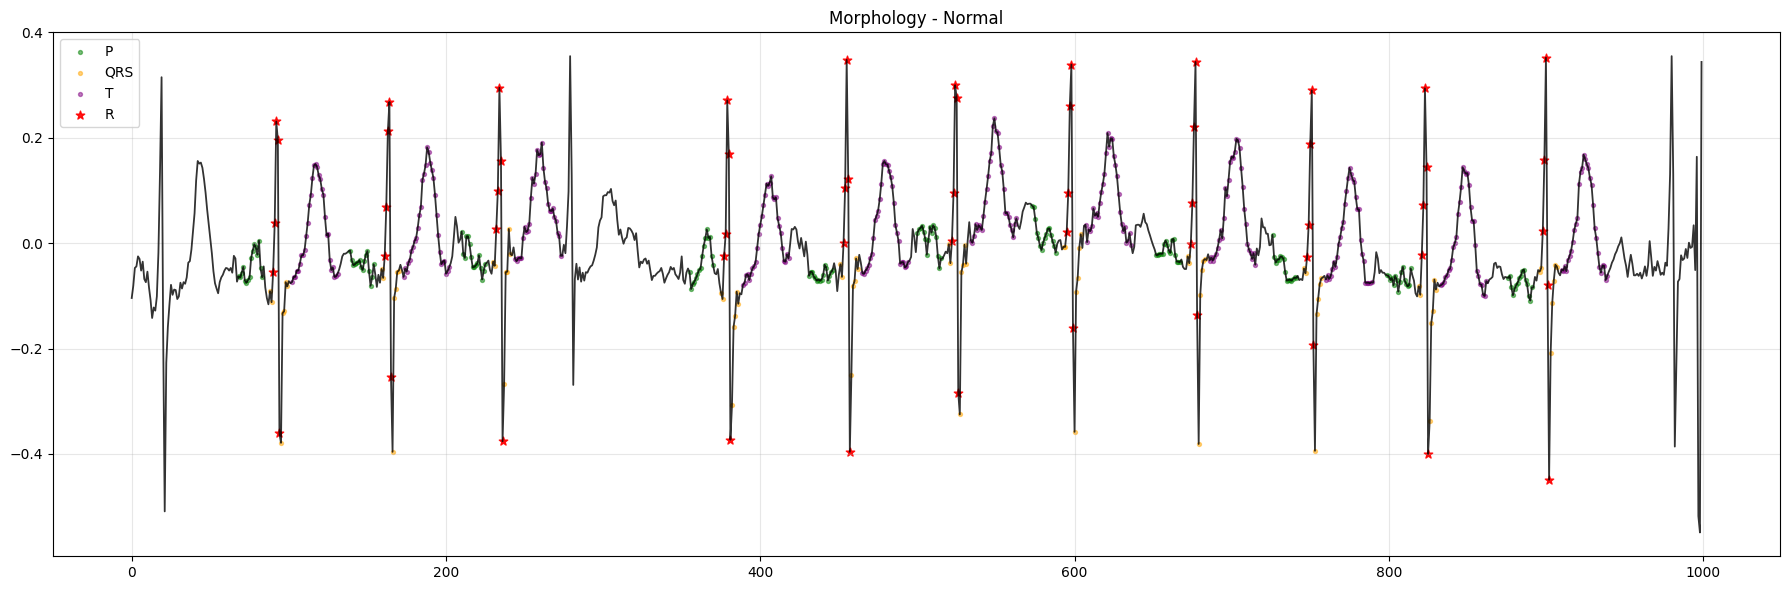

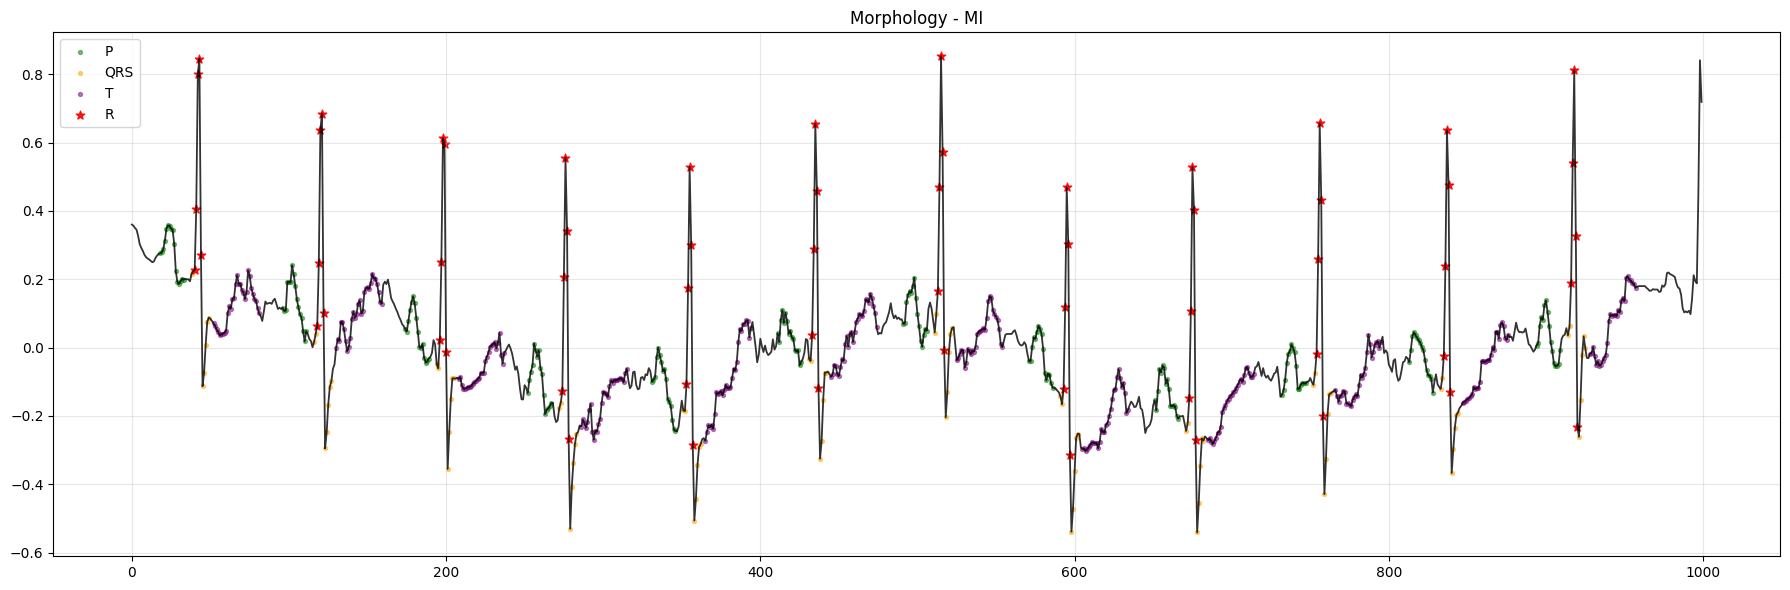

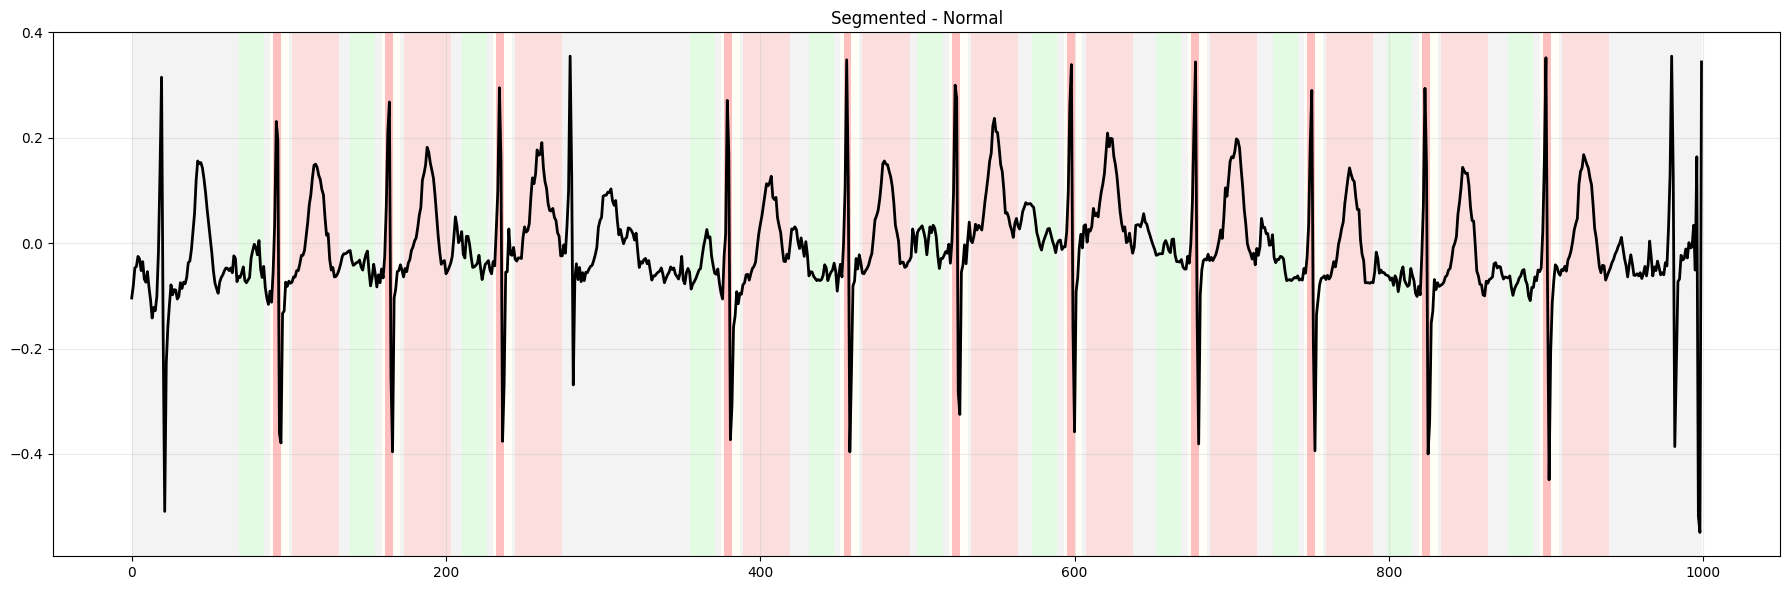

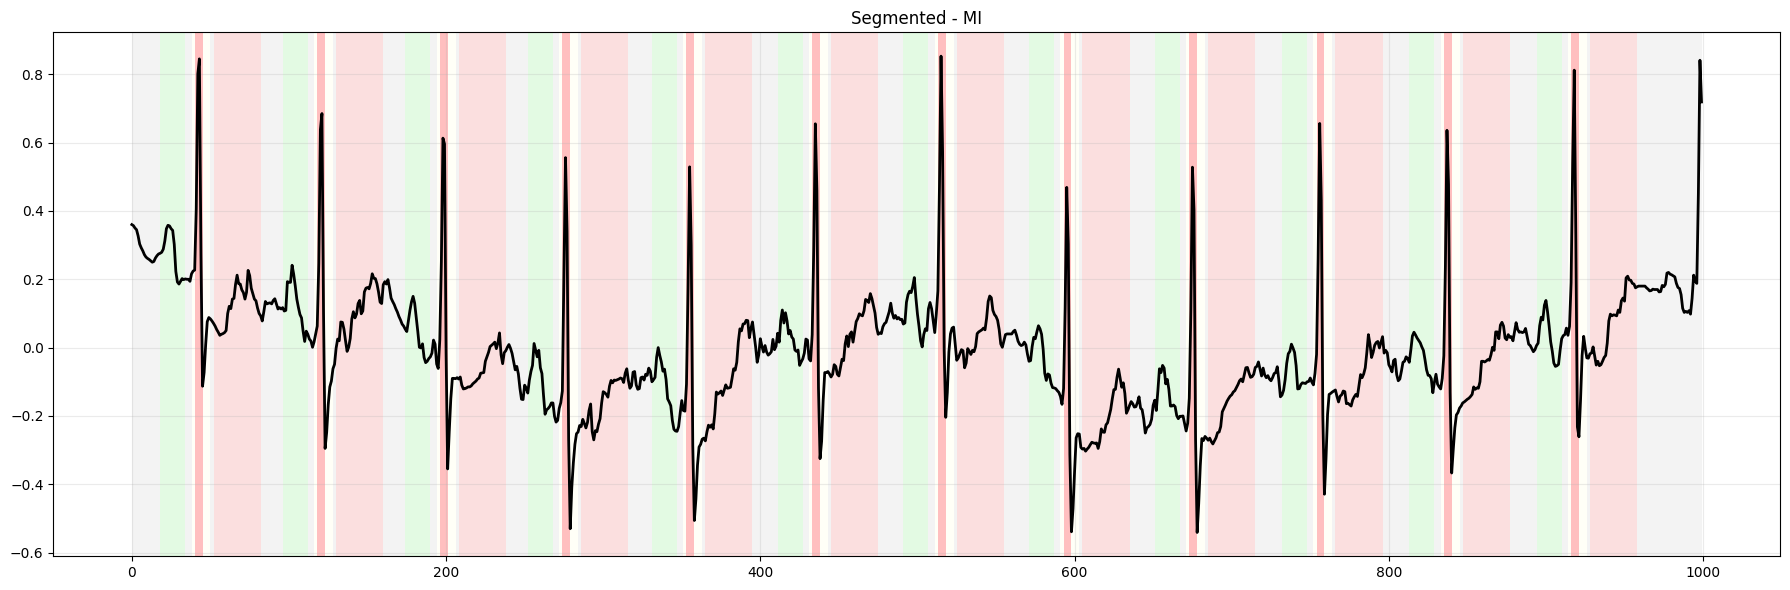

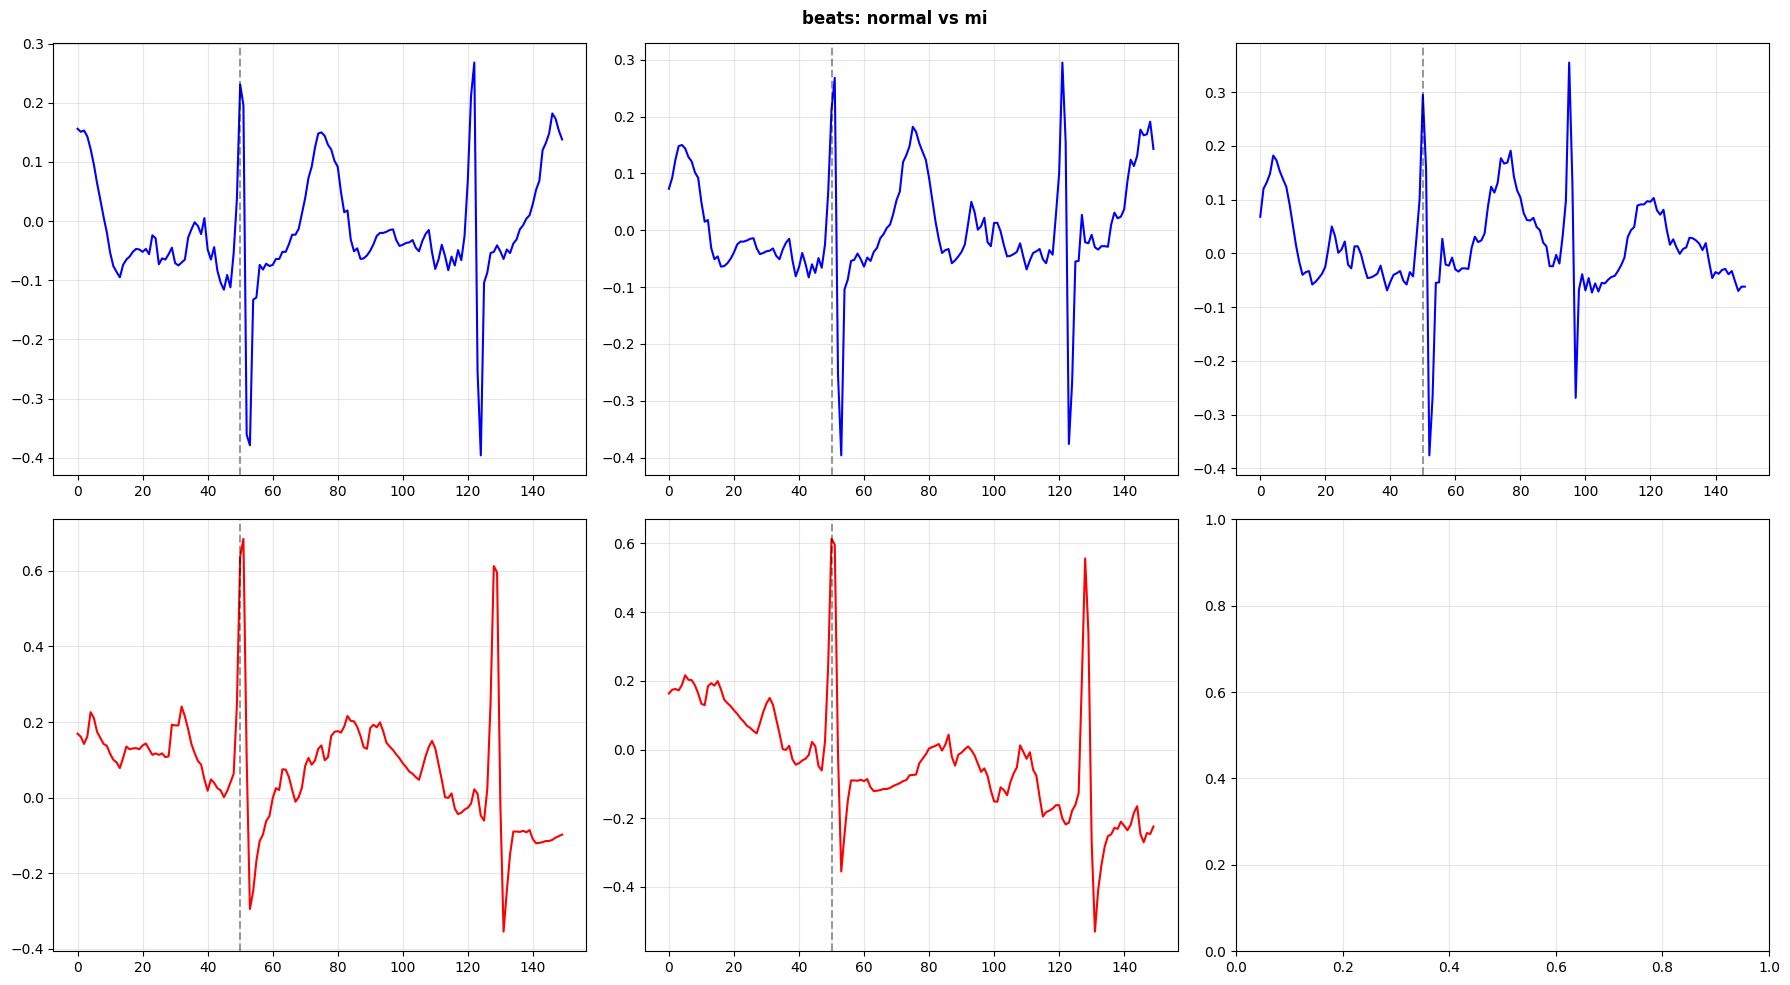

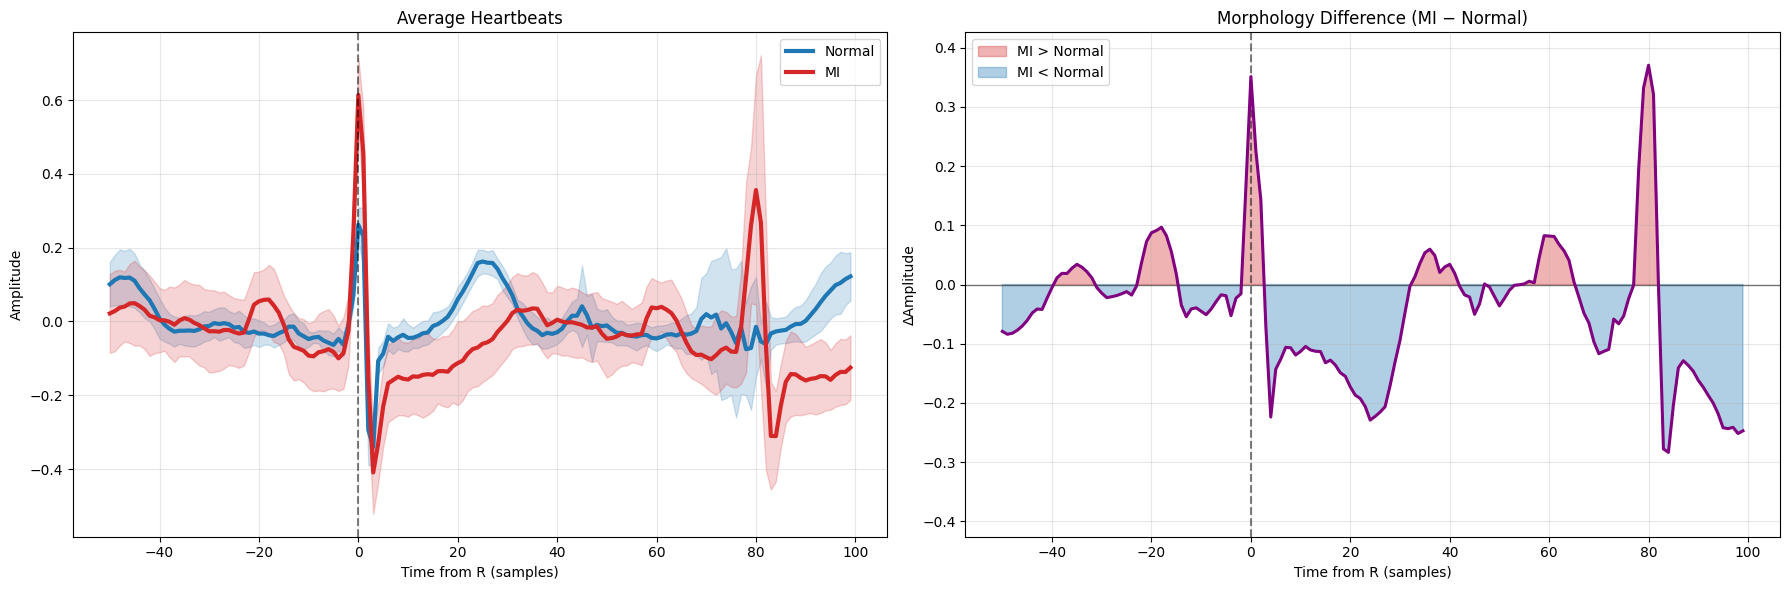

In [ ]:
# here, we load saved model rpeak_cnn.h5 and make plots on random PTB-XL samples
import os, ast
import numpy as np
import pandas as pd
import wfdb
import neurokit2 as nk
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def dice(y_true, y_pred, eps=1e-6):
    yt = tf.reshape(y_true, [-1]); yp = tf.reshape(y_pred, [-1])
    inter = tf.reduce_sum(yt * yp)
    return (2.*inter + eps) / (tf.reduce_sum(yt) + tf.reduce_sum(yp) + eps)

def pick_peaks_from_mask(mask, thr=0.5, min_dist=50):
    b = (mask > thr).astype(int).flatten()
    peaks, i = [], 0
    while i < len(b):
        if b[i] == 1:
            s = i
            while i < len(b) and b[i] == 1: i += 1
            e = i
            peaks.append((s+e)//2)
            i = e + min_dist
        else:
            i += 1
    return np.array(peaks)

def annotate_waves(sig, r_idx, fs=100):
    if sig.ndim > 1: sig = sig[:, 1]
    lab = np.zeros(len(sig))
    try:
        clean = nk.ecg_clean(sig, sampling_rate=fs)
        _, w = nk.ecg_delineate(clean, r_idx, sampling_rate=fs, method='dwt')
        if w.get('ECG_P_Peaks') is not None:
            p = w['ECG_P_Peaks']; p = p[~np.isnan(p)].astype(int)
            for k in p:
                a = max(0, k - int(0.04*fs)); b = min(len(sig), k + int(0.04*fs)); lab[a:b] = 1
        if w.get('ECG_R_Onsets') is not None and w.get('ECG_R_Offsets') is not None:
            q = w['ECG_R_Onsets']; s = w['ECG_R_Offsets']
            q = q[~np.isnan(q)].astype(int); s = s[~np.isnan(s)].astype(int)
            for a, b in zip(q, s):
                if 0 <= a < len(sig) and 0 <= b < len(sig): lab[a:b] = 2
        if w.get('ECG_T_Peaks') is not None:
            t = w['ECG_T_Peaks']; t = t[~np.isnan(t)].astype(int)
            for k in t:
                a = max(0, k - int(0.06*fs)); b = min(len(sig), k + int(0.06*fs)); lab[a:b] = 3
        for r in r_idx:
            a = max(0, r - 2); b = min(len(sig), r + 3); lab[a:b] = 4
    except:
        # simple fallback
        for r in r_idx:
            p1 = max(0, r - int(0.24*fs)); p2 = max(0, r - int(0.08*fs)); lab[p1:p2] = 1
            q1 = max(0, r - int(0.04*fs)); q2 = min(len(sig), r + int(0.08*fs)); lab[q1:q2] = 2
            t1 = min(len(sig), r + int(0.10*fs)); t2 = min(len(sig), r + int(0.40*fs)); lab[t1:t2] = 3
            a = max(0, r - 2); b = min(len(sig), r + 3); lab[a:b] = 4
    return lab

# plotting
def plot_rpeak_detection(sig, cnn_peaks, nk_peaks, title):
    plt.figure(figsize=(16,5))
    plt.plot(sig, lw=1.2, alpha=0.8, label='ECG')
    if len(nk_peaks):  plt.scatter(nk_peaks,  sig[nk_peaks],  s=120, c='g', marker='*', label='NeuroKit2')
    if len(cnn_peaks): plt.scatter(cnn_peaks, sig[cnn_peaks], s=90,  c='r', marker='x', label='CNN')
    plt.title(title); plt.xlabel('sample'); plt.ylabel('amp'); plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()

def plot_wave_annotation(sig, waves, peaks, title):
    fig, ax = plt.subplots(figsize=(18,6))
    ax.plot(sig, color='k', lw=1.3, alpha=0.8)
    colors = {1:'green', 2:'orange', 3:'purple', 4:'red'}
    names  = {1:'P',     2:'QRS',    3:'T',      4:'R'}
    for w in [1,2,3,4]:
        idx = np.where(waves==w)[0]
        if len(idx):
            ax.scatter(idx, sig[idx], s=(40 if w==4 else 8),
                       c=colors[w], marker=('*' if w==4 else 'o'),
                       alpha=(0.9 if w==4 else 0.5), label=names[w])
    ax.set_title(title); ax.legend(); ax.grid(alpha=0.3); plt.tight_layout()

def plot_segmented_ecg_regions(sig, waves, peaks, title):
    fig, ax = plt.subplots(figsize=(18,6))
    shades = ['lightgray','lightgreen','lightyellow','lightcoral','red']
    for i in range(len(sig)-1):
        ax.axvspan(i, i+1, facecolor=shades[int(waves[i])], alpha=0.25)
    ax.plot(sig, color='black', lw=2)
    ax.set_title(title); ax.grid(alpha=0.25); plt.tight_layout()

def plot_heartbeat_comparison(norm_sig, mi_sig, norm_peaks, mi_peaks):
    fig, axs = plt.subplots(2,3, figsize=(18,10)); fig.suptitle('beats: normal vs mi', fontweight='bold')
    before, after = 50, 100
    def beats(sig, r, n=3):
        out=[]
        for pk in r[:n]:
            if pk>before and pk<len(sig)-after: out.append(sig[pk-before:pk+after])
        return out
    bn, bm = beats(norm_sig, norm_peaks), beats(mi_sig, mi_peaks)
    for i in range(3):
        if i<len(bn): axs[0,i].plot(bn[i], 'b'); axs[0,i].axvline(before, ls='--', c='k', alpha=0.4)
        if i<len(bm): axs[1,i].plot(bm[i], 'r'); axs[1,i].axvline(before, ls='--', c='k', alpha=0.4)
        axs[0,i].grid(alpha=0.3); axs[1,i].grid(alpha=0.3)
    plt.tight_layout()

def plot_average_morphology(norm_sig, mi_sig, norm_peaks, mi_peaks, before=50, after=100):
    # collect fixed length beats around R
    def _avg(sig, r):
        beats = []
        for k in r:
            if k > before and k < len(sig) - after:
                beats.append(sig[k-before:k+after])
        if not beats:
            return None, None
        B = np.stack(beats).astype(float)
        return B.mean(0), B.std(0)

    n_avg, n_std = _avg(norm_sig, norm_peaks)
    m_avg, m_std = _avg(mi_sig,   mi_peaks)
    if n_avg is None or m_avg is None:
        print("not enough beats");
        return

    # time axis
    t = np.arange(-before, after)

    fig, ax = plt.subplots(1, 2, figsize=(18, 6))

    # (left) average beats with bands
    ax[0].plot(t, n_avg, color='tab:blue', lw=3, label='Normal')
    ax[0].fill_between(t, n_avg - n_std, n_avg + n_std, color='tab:blue', alpha=0.2)
    ax[0].plot(t, m_avg, color='tab:red', lw=3, label='MI')
    ax[0].fill_between(t, m_avg - m_std, m_avg + m_std, color='tab:red', alpha=0.2)
    ax[0].axvline(0, ls='--', c='k', alpha=0.5)
    ax[0].grid(alpha=0.3); ax[0].legend()
    ax[0].set_title('Average Heartbeats');
    ax[0].set_xlabel('Time from R (samples)'); ax[0].set_ylabel('Amplitude')

    # (right) MI - Normal with CLEAR color shading
    diff = m_avg - n_avg
    ax[1].axhline(0, c='k', lw=1, alpha=0.5)
    ax[1].axvline(0, ls='--', c='k', alpha=0.5)

    # red where MI > Normal, blue where MI < Normal
    ax[1].fill_between(t, 0, diff, where=(diff >= 0), interpolate=True,
                       color='tab:red', alpha=0.35, label='MI > Normal')
    ax[1].fill_between(t, 0, diff, where=(diff < 0), interpolate=True,
                       color='tab:blue', alpha=0.35, label='MI < Normal')

    ax[1].plot(t, diff, color='purple', lw=2.2)
    # nice symmetric y-lims
    ylim = np.nanmax(np.abs(diff)) * 1.15
    if np.isfinite(ylim) and ylim > 0:
        ax[1].set_ylim(-ylim, ylim)

    ax[1].grid(alpha=0.3); ax[1].legend()
    ax[1].set_title('Morphology Difference (MI − Normal)')
    ax[1].set_xlabel('Time from R (samples)'); ax[1].set_ylabel('ΔAmplitude')

    plt.tight_layout()

#very small PTB-XL loader
class ECGLoader:
    def __init__(self):
        base = '/kaggle/input/ptb-xl-dataset/'
        self.root = None
        for d in os.listdir(base):
            p = os.path.join(base, d)
            if os.path.isdir(p) and os.path.exists(os.path.join(p, 'ptbxl_database.csv')):
                self.root = p + '/'
                break
        if self.root is None: raise FileNotFoundError("PTB-XL path not found")
    def _csv(self):
        df = pd.read_csv(os.path.join(self.root, 'ptbxl_database.csv'), index_col='ecg_id')
        df.scp_codes = df.scp_codes.apply(lambda x: ast.literal_eval(x))
        return df
    def split_norm_mi(self):
        df = self._csv()
        mi_tags = ['IMI','AMI','ASMI','ILMI','IPLMI','IPMI','PMI','LMI','ALMI','INJAS','INJAL','INJIL','INJIN','INJLA']
        norm = df[df.scp_codes.apply(lambda x: 'NORM' in x)]
        mi   = df[df.scp_codes.apply(lambda x: any(t in x for t in mi_tags))]
        return norm, mi
    def read_ecg(self, relpath):
        return wfdb.rdsamp(os.path.join(self.root, relpath))[0]

# load model
fs = 100
MODEL_PATH = "rpeak_cnn.h5"
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"missing model: {MODEL_PATH}")
model = keras.models.load_model(MODEL_PATH, custom_objects={'dice': dice}, compile=False)
print("model loaded")

# random normal and MI sample selection
ldr = ECGLoader()
df_norm, df_mi = ldr.split_norm_mi()
row_norm = df_norm.sample(1).iloc[0]
row_mi   = df_mi.sample(1).iloc[0]

ecg_norm = ldr.read_ecg(row_norm["filename_lr"])
ecg_mi   = ldr.read_ecg(row_mi["filename_lr"])
sig_norm = ecg_norm[:, 1]
sig_mi   = ecg_mi[:, 1]

# clean, reference peaks
sig_norm_clean = nk.ecg_clean(sig_norm, sampling_rate=fs)
sig_mi_clean   = nk.ecg_clean(sig_mi,   sampling_rate=fs)
_, nk_norm = nk.ecg_peaks(sig_norm_clean, sampling_rate=fs, method="neurokit")
_, nk_mi   = nk.ecg_peaks(sig_mi_clean,   sampling_rate=fs, method="neurokit")
nk_peaks_norm = nk_norm["ECG_R_Peaks"]
nk_peaks_mi   = nk_mi["ECG_R_Peaks"]

# predict mask r peaks
pred_norm = model.predict(sig_norm_clean.reshape(1, -1, 1), verbose=0)[0]
pred_mi   = model.predict(sig_mi_clean.reshape(1, -1, 1),   verbose=0)[0]
cnn_peaks_norm = pick_peaks_from_mask(pred_norm, thr=0.5, min_dist=50)
cnn_peaks_mi   = pick_peaks_from_mask(pred_mi,   thr=0.5, min_dist=50)

print("normal:", row_norm["filename_lr"], "| nk:", len(nk_peaks_norm), "cnn:", len(cnn_peaks_norm))
print("mi    :", row_mi["filename_lr"],   "| nk:", len(nk_peaks_mi),   "cnn:", len(cnn_peaks_mi))

# labels from CNN peaks
waves_norm = annotate_waves(sig_norm, cnn_peaks_norm, fs=fs)
waves_mi   = annotate_waves(sig_mi,   cnn_peaks_mi,   fs=fs)

# make figures (saved with .png)
plot_rpeak_detection(sig_norm_clean, cnn_peaks_norm, nk_peaks_norm, "R-Peak Detection - Normal (CNN vs NeuroKit2)")
plt.savefig("/kaggle/working/rpeak_normal_rand.png", dpi=150, bbox_inches="tight"); plt.show()

plot_rpeak_detection(sig_mi_clean, cnn_peaks_mi, nk_peaks_mi, "R-Peak Detection - MI (CNN vs NeuroKit2)")
plt.savefig("/kaggle/working/rpeak_mi_rand.png",     dpi=150, bbox_inches="tight"); plt.show()

plot_wave_annotation(sig_norm, waves_norm, cnn_peaks_norm, "Morphology - Normal")
plt.savefig("/kaggle/working/annotation_normal_rand.png", dpi=150, bbox_inches="tight"); plt.show()

plot_wave_annotation(sig_mi, waves_mi, cnn_peaks_mi, "Morphology - MI")
plt.savefig("/kaggle/working/annotation_mi_rand.png", dpi=150, bbox_inches="tight"); plt.show()

plot_segmented_ecg_regions(sig_norm, waves_norm, cnn_peaks_norm, "Segmented - Normal")
plt.savefig("/kaggle/working/segmented_normal_rand.png", dpi=150, bbox_inches="tight"); plt.show()

plot_segmented_ecg_regions(sig_mi, waves_mi, cnn_peaks_mi, "Segmented - MI")
plt.savefig("/kaggle/working/q2_segmented_mi_rand.png", dpi=150, bbox_inches="tight"); plt.show()

plot_heartbeat_comparison(sig_norm, sig_mi, cnn_peaks_norm, cnn_peaks_mi)
plt.savefig("/kaggle/working/heartbeat_comparison_rand.png", dpi=150, bbox_inches="tight"); plt.show()

plot_average_morphology(sig_norm, sig_mi, cnn_peaks_norm, cnn_peaks_mi)
plt.savefig("/kaggle/working/average_morphology_rand.png", dpi=150, bbox_inches="tight"); plt.show()


model loaded
normal: records100/18000/18639_lr | nk: 9 cnn: 9
mi    : records100/18000/18317_lr | nk: 12 cnn: 11


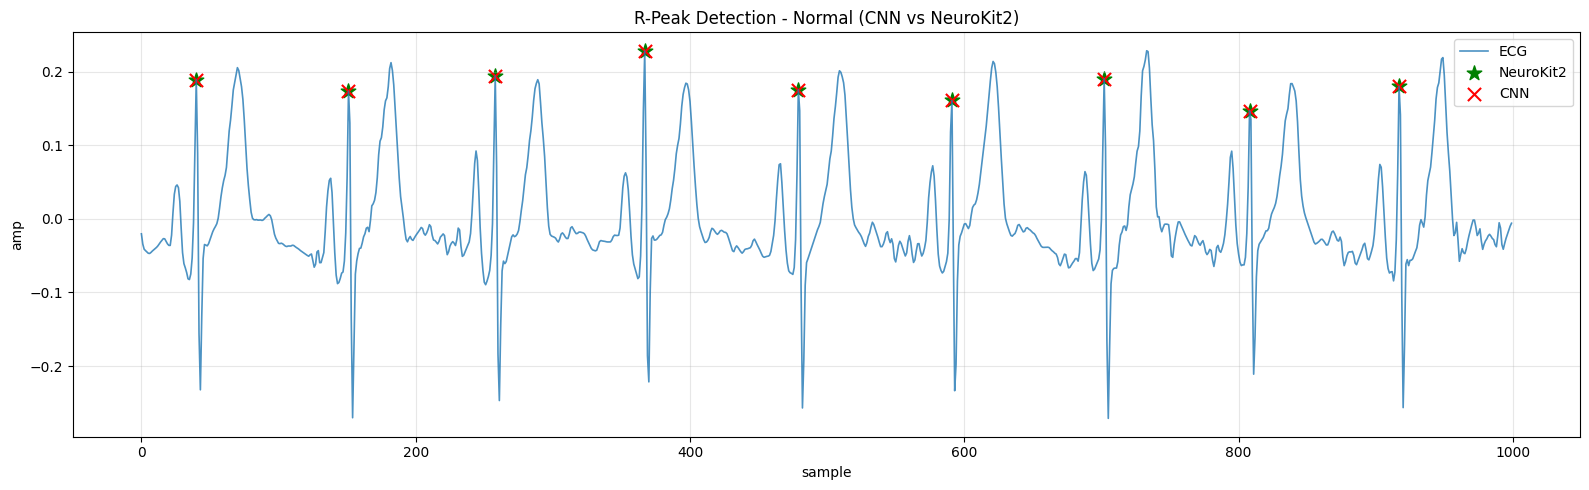

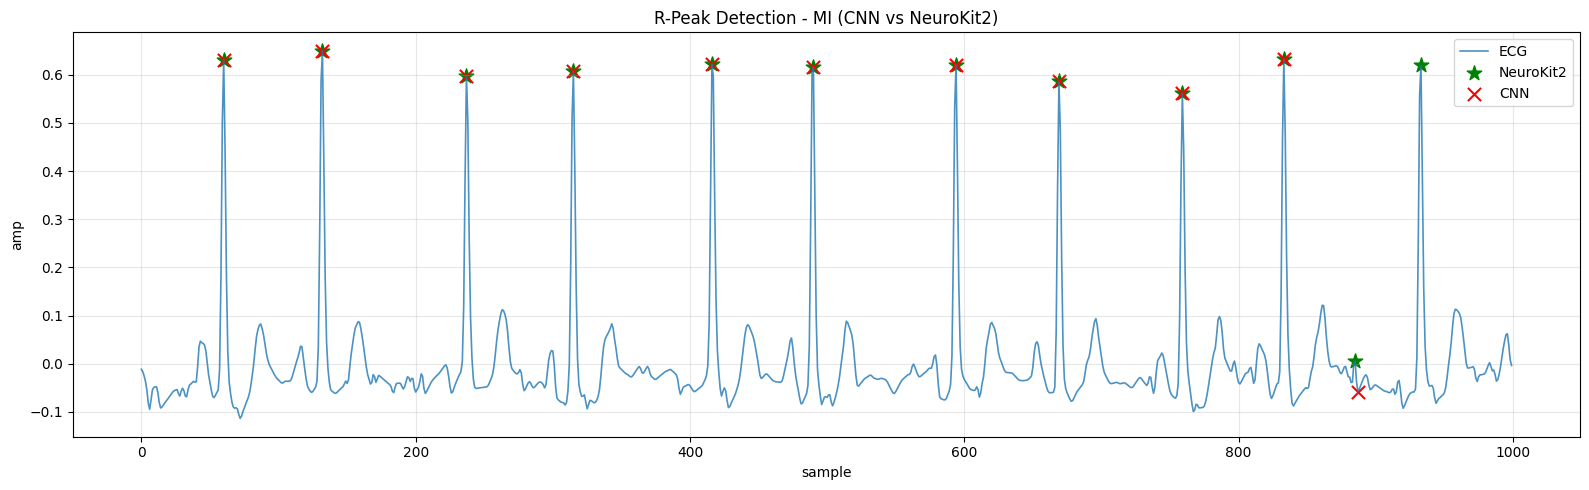

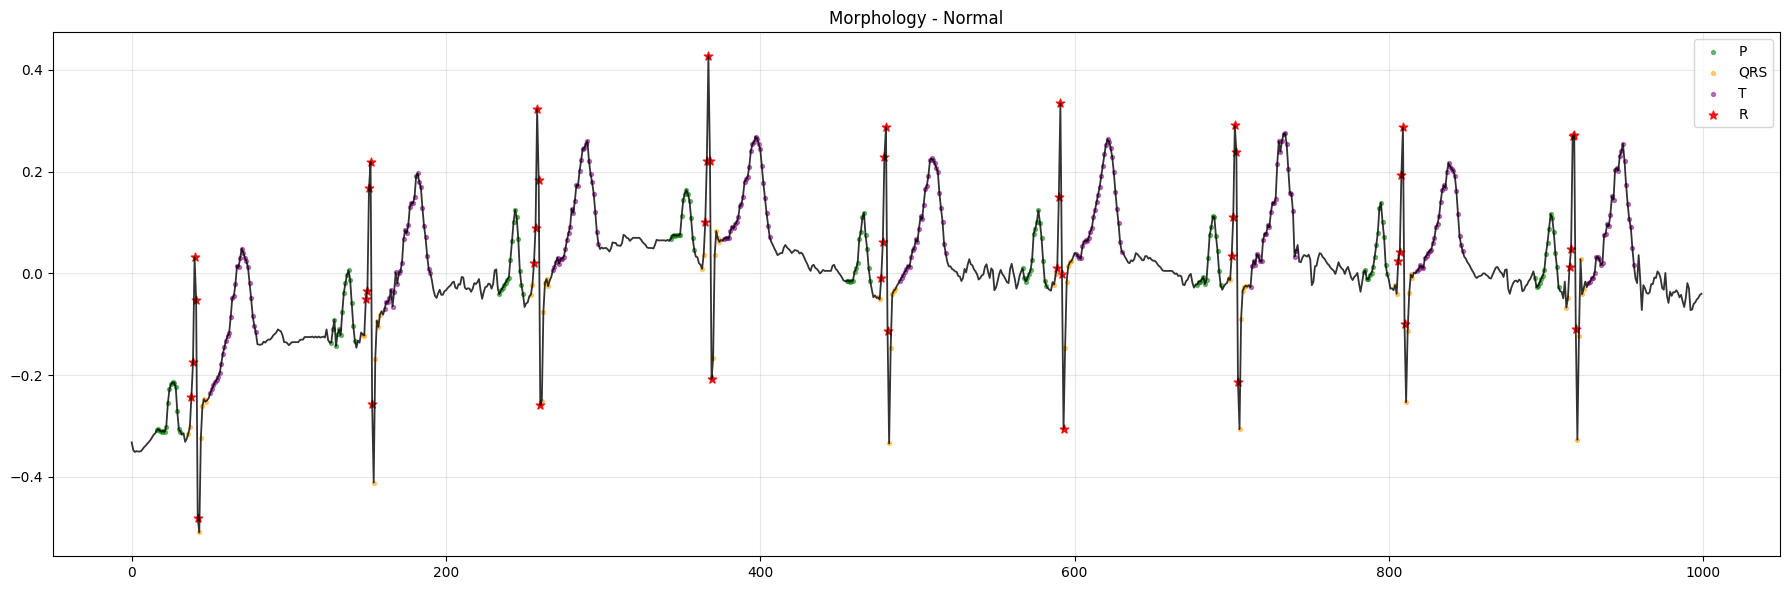

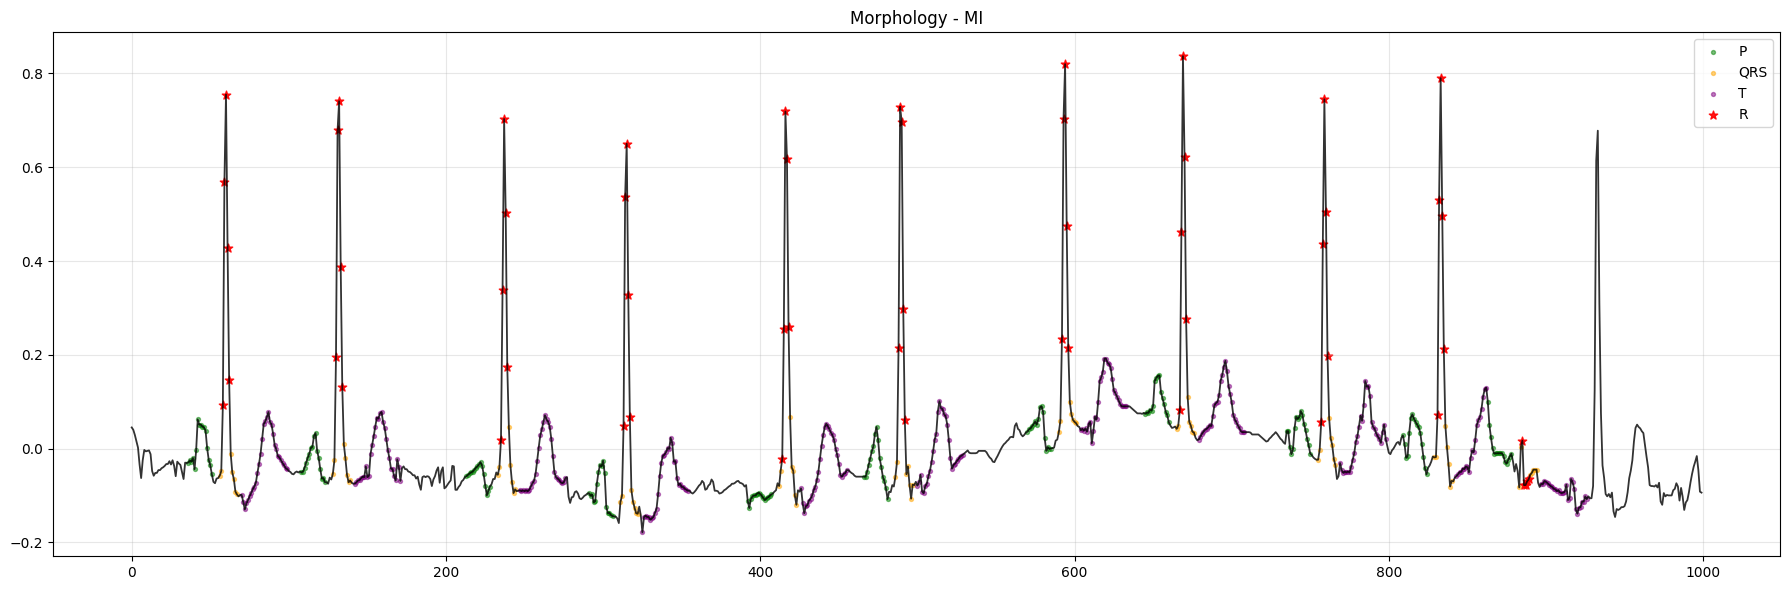

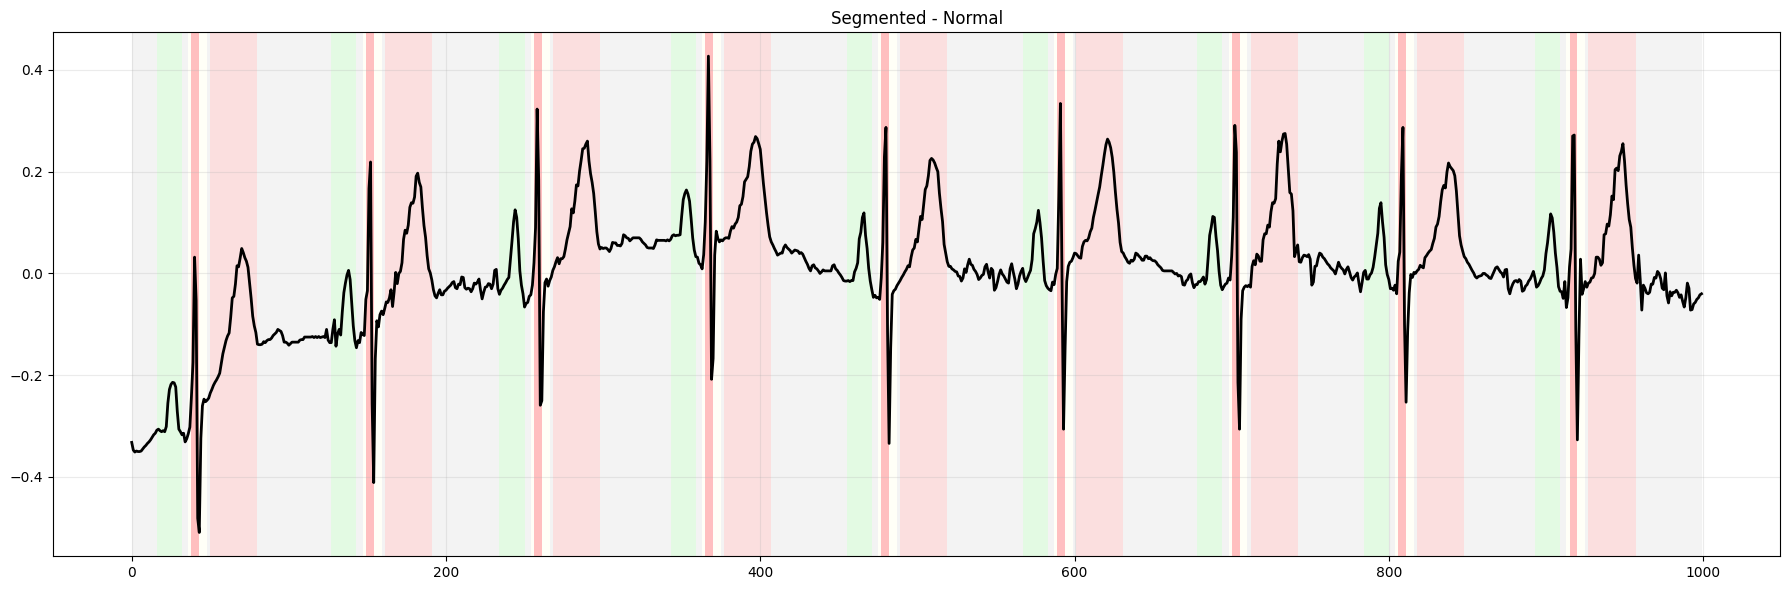

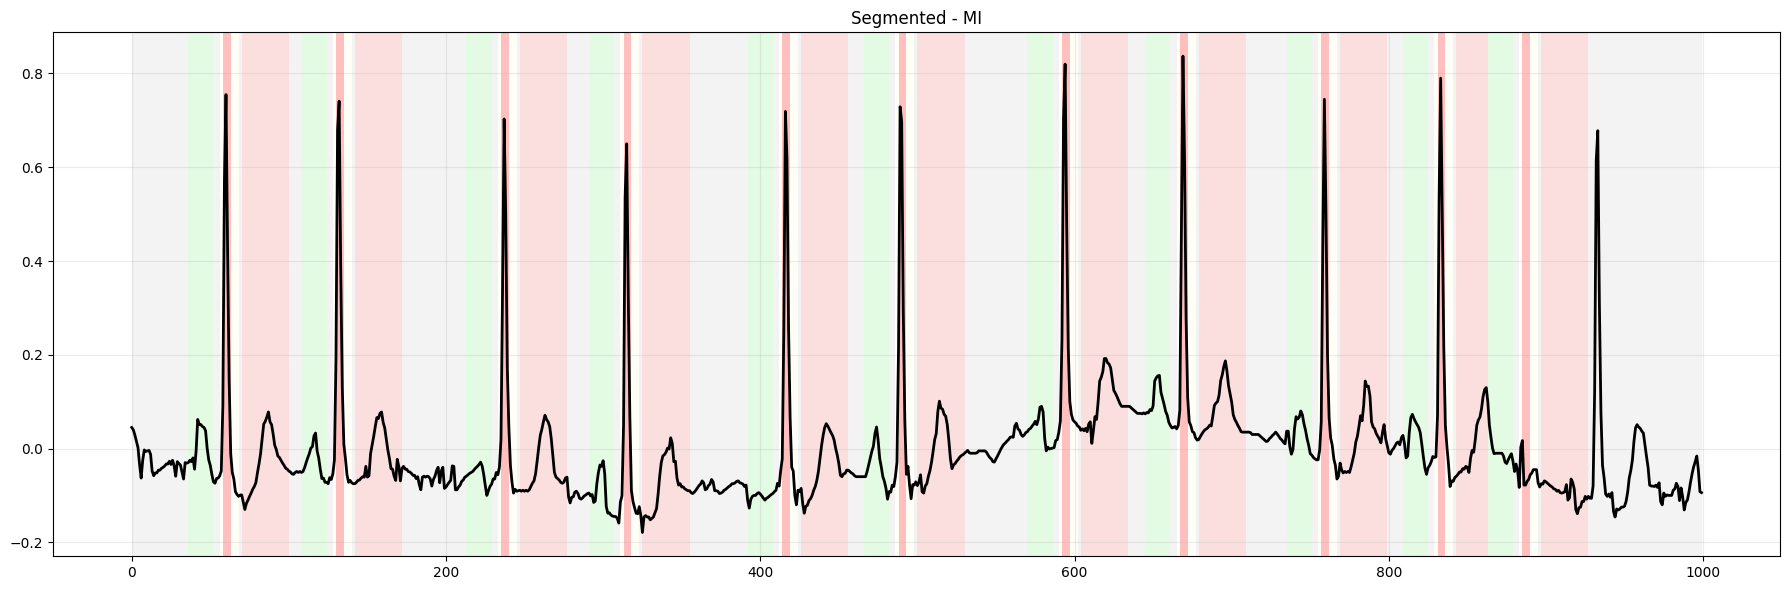

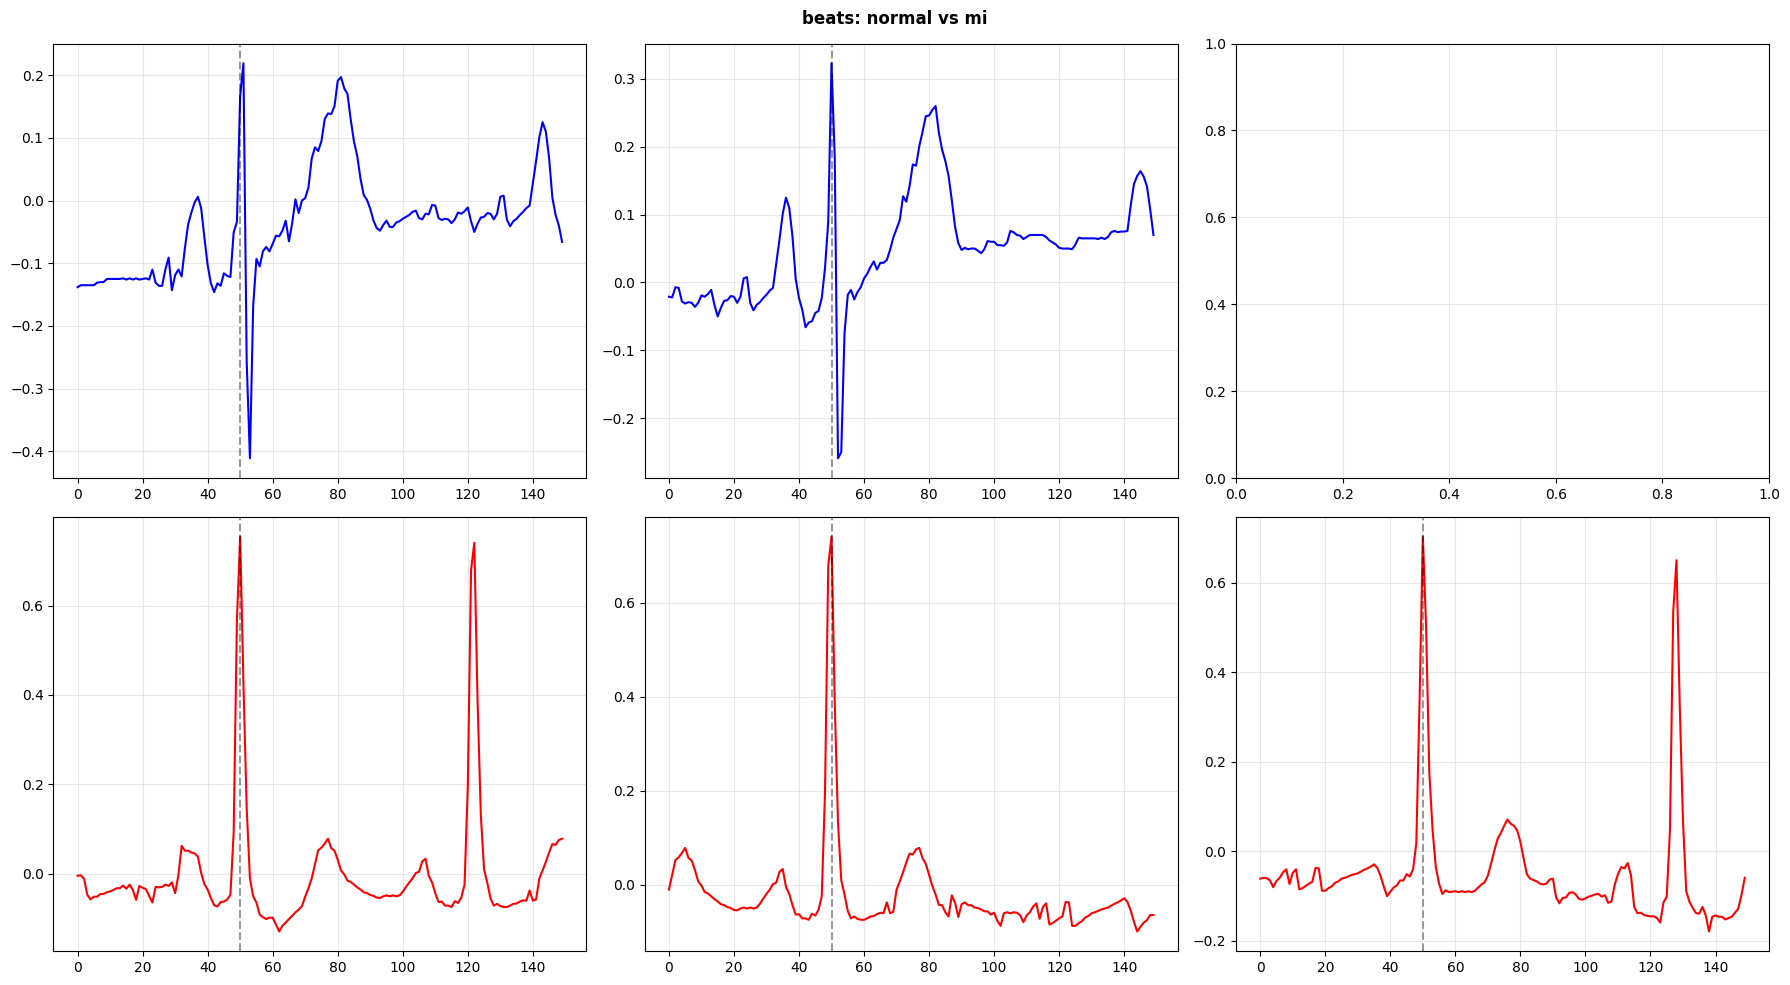

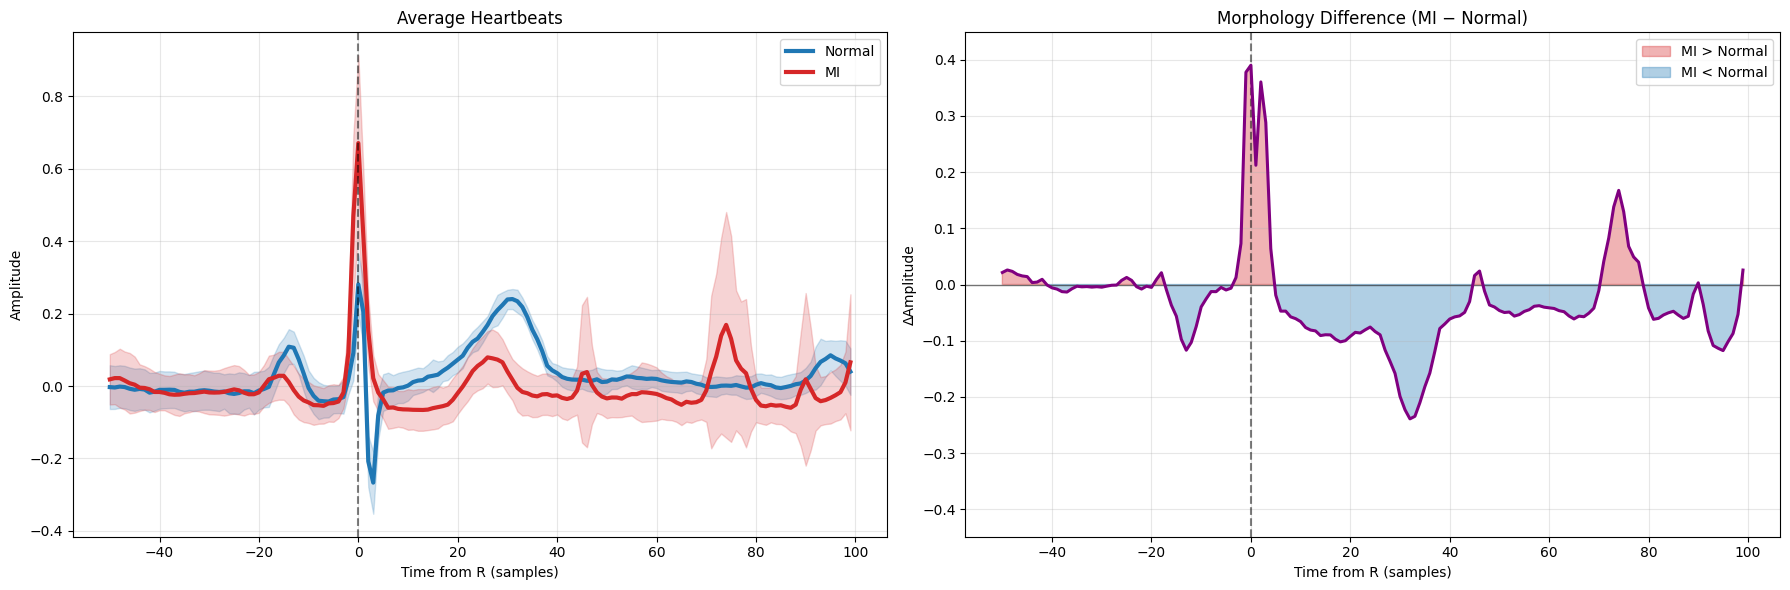

In [ ]:
# here, we load saved model rpeak_cnn.h5 and make plots on random PTB-XL samples
import os, ast
import numpy as np
import pandas as pd
import wfdb
import neurokit2 as nk
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def dice(y_true, y_pred, eps=1e-6):
    yt = tf.reshape(y_true, [-1]); yp = tf.reshape(y_pred, [-1])
    inter = tf.reduce_sum(yt * yp)
    return (2.*inter + eps) / (tf.reduce_sum(yt) + tf.reduce_sum(yp) + eps)

def pick_peaks_from_mask(mask, thr=0.5, min_dist=50):
    b = (mask > thr).astype(int).flatten()
    peaks, i = [], 0
    while i < len(b):
        if b[i] == 1:
            s = i
            while i < len(b) and b[i] == 1: i += 1
            e = i
            peaks.append((s+e)//2)
            i = e + min_dist
        else:
            i += 1
    return np.array(peaks)

def annotate_waves(sig, r_idx, fs=100):
    if sig.ndim > 1: sig = sig[:, 1]
    lab = np.zeros(len(sig))
    try:
        clean = nk.ecg_clean(sig, sampling_rate=fs)
        _, w = nk.ecg_delineate(clean, r_idx, sampling_rate=fs, method='dwt')
        if w.get('ECG_P_Peaks') is not None:
            p = w['ECG_P_Peaks']; p = p[~np.isnan(p)].astype(int)
            for k in p:
                a = max(0, k - int(0.04*fs)); b = min(len(sig), k + int(0.04*fs)); lab[a:b] = 1
        if w.get('ECG_R_Onsets') is not None and w.get('ECG_R_Offsets') is not None:
            q = w['ECG_R_Onsets']; s = w['ECG_R_Offsets']
            q = q[~np.isnan(q)].astype(int); s = s[~np.isnan(s)].astype(int)
            for a, b in zip(q, s):
                if 0 <= a < len(sig) and 0 <= b < len(sig): lab[a:b] = 2
        if w.get('ECG_T_Peaks') is not None:
            t = w['ECG_T_Peaks']; t = t[~np.isnan(t)].astype(int)
            for k in t:
                a = max(0, k - int(0.06*fs)); b = min(len(sig), k + int(0.06*fs)); lab[a:b] = 3
        for r in r_idx:
            a = max(0, r - 2); b = min(len(sig), r + 3); lab[a:b] = 4
    except:
        # simple fallback
        for r in r_idx:
            p1 = max(0, r - int(0.24*fs)); p2 = max(0, r - int(0.08*fs)); lab[p1:p2] = 1
            q1 = max(0, r - int(0.04*fs)); q2 = min(len(sig), r + int(0.08*fs)); lab[q1:q2] = 2
            t1 = min(len(sig), r + int(0.10*fs)); t2 = min(len(sig), r + int(0.40*fs)); lab[t1:t2] = 3
            a = max(0, r - 2); b = min(len(sig), r + 3); lab[a:b] = 4
    return lab

# plotting
def plot_rpeak_detection(sig, cnn_peaks, nk_peaks, title):
    plt.figure(figsize=(16,5))
    plt.plot(sig, lw=1.2, alpha=0.8, label='ECG')
    if len(nk_peaks):  plt.scatter(nk_peaks,  sig[nk_peaks],  s=120, c='g', marker='*', label='NeuroKit2')
    if len(cnn_peaks): plt.scatter(cnn_peaks, sig[cnn_peaks], s=90,  c='r', marker='x', label='CNN')
    plt.title(title); plt.xlabel('sample'); plt.ylabel('amp'); plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()

def plot_wave_annotation(sig, waves, peaks, title):
    fig, ax = plt.subplots(figsize=(18,6))
    ax.plot(sig, color='k', lw=1.3, alpha=0.8)
    colors = {1:'green', 2:'orange', 3:'purple', 4:'red'}
    names  = {1:'P',     2:'QRS',    3:'T',      4:'R'}
    for w in [1,2,3,4]:
        idx = np.where(waves==w)[0]
        if len(idx):
            ax.scatter(idx, sig[idx], s=(40 if w==4 else 8),
                       c=colors[w], marker=('*' if w==4 else 'o'),
                       alpha=(0.9 if w==4 else 0.5), label=names[w])
    ax.set_title(title); ax.legend(); ax.grid(alpha=0.3); plt.tight_layout()

def plot_segmented_ecg_regions(sig, waves, peaks, title):
    fig, ax = plt.subplots(figsize=(18,6))
    shades = ['lightgray','lightgreen','lightyellow','lightcoral','red']
    for i in range(len(sig)-1):
        ax.axvspan(i, i+1, facecolor=shades[int(waves[i])], alpha=0.25)
    ax.plot(sig, color='black', lw=2)
    ax.set_title(title); ax.grid(alpha=0.25); plt.tight_layout()

def plot_heartbeat_comparison(norm_sig, mi_sig, norm_peaks, mi_peaks):
    fig, axs = plt.subplots(2,3, figsize=(18,10)); fig.suptitle('beats: normal vs mi', fontweight='bold')
    before, after = 50, 100
    def beats(sig, r, n=3):
        out=[]
        for pk in r[:n]:
            if pk>before and pk<len(sig)-after: out.append(sig[pk-before:pk+after])
        return out
    bn, bm = beats(norm_sig, norm_peaks), beats(mi_sig, mi_peaks)
    for i in range(3):
        if i<len(bn): axs[0,i].plot(bn[i], 'b'); axs[0,i].axvline(before, ls='--', c='k', alpha=0.4)
        if i<len(bm): axs[1,i].plot(bm[i], 'r'); axs[1,i].axvline(before, ls='--', c='k', alpha=0.4)
        axs[0,i].grid(alpha=0.3); axs[1,i].grid(alpha=0.3)
    plt.tight_layout()

def plot_average_morphology(norm_sig, mi_sig, norm_peaks, mi_peaks, before=50, after=100):
    # collect fixed length beats around R
    def _avg(sig, r):
        beats = []
        for k in r:
            if k > before and k < len(sig) - after:
                beats.append(sig[k-before:k+after])
        if not beats:
            return None, None
        B = np.stack(beats).astype(float)
        return B.mean(0), B.std(0)

    n_avg, n_std = _avg(norm_sig, norm_peaks)
    m_avg, m_std = _avg(mi_sig,   mi_peaks)
    if n_avg is None or m_avg is None:
        print("not enough beats");
        return

    # time axis
    t = np.arange(-before, after)

    fig, ax = plt.subplots(1, 2, figsize=(18, 6))

    # (left) average beats with bands
    ax[0].plot(t, n_avg, color='tab:blue', lw=3, label='Normal')
    ax[0].fill_between(t, n_avg - n_std, n_avg + n_std, color='tab:blue', alpha=0.2)
    ax[0].plot(t, m_avg, color='tab:red', lw=3, label='MI')
    ax[0].fill_between(t, m_avg - m_std, m_avg + m_std, color='tab:red', alpha=0.2)
    ax[0].axvline(0, ls='--', c='k', alpha=0.5)
    ax[0].grid(alpha=0.3); ax[0].legend()
    ax[0].set_title('Average Heartbeats');
    ax[0].set_xlabel('Time from R (samples)'); ax[0].set_ylabel('Amplitude')

    # (right) MI - Normal with CLEAR color shading
    diff = m_avg - n_avg
    ax[1].axhline(0, c='k', lw=1, alpha=0.5)
    ax[1].axvline(0, ls='--', c='k', alpha=0.5)

    # red where MI > Normal, blue where MI < Normal
    ax[1].fill_between(t, 0, diff, where=(diff >= 0), interpolate=True,
                       color='tab:red', alpha=0.35, label='MI > Normal')
    ax[1].fill_between(t, 0, diff, where=(diff < 0), interpolate=True,
                       color='tab:blue', alpha=0.35, label='MI < Normal')

    ax[1].plot(t, diff, color='purple', lw=2.2)
    # nice symmetric y-lims
    ylim = np.nanmax(np.abs(diff)) * 1.15
    if np.isfinite(ylim) and ylim > 0:
        ax[1].set_ylim(-ylim, ylim)

    ax[1].grid(alpha=0.3); ax[1].legend()
    ax[1].set_title('Morphology Difference (MI − Normal)')
    ax[1].set_xlabel('Time from R (samples)'); ax[1].set_ylabel('ΔAmplitude')

    plt.tight_layout()

#very small PTB-XL loader
class ECGLoader:
    def __init__(self):
        base = '/kaggle/input/ptb-xl-dataset/'
        self.root = None
        for d in os.listdir(base):
            p = os.path.join(base, d)
            if os.path.isdir(p) and os.path.exists(os.path.join(p, 'ptbxl_database.csv')):
                self.root = p + '/'
                break
        if self.root is None: raise FileNotFoundError("PTB-XL path not found")
    def _csv(self):
        df = pd.read_csv(os.path.join(self.root, 'ptbxl_database.csv'), index_col='ecg_id')
        df.scp_codes = df.scp_codes.apply(lambda x: ast.literal_eval(x))
        return df
    def split_norm_mi(self):
        df = self._csv()
        mi_tags = ['IMI','AMI','ASMI','ILMI','IPLMI','IPMI','PMI','LMI','ALMI','INJAS','INJAL','INJIL','INJIN','INJLA']
        norm = df[df.scp_codes.apply(lambda x: 'NORM' in x)]
        mi   = df[df.scp_codes.apply(lambda x: any(t in x for t in mi_tags))]
        return norm, mi
    def read_ecg(self, relpath):
        return wfdb.rdsamp(os.path.join(self.root, relpath))[0]

# load model
fs = 100
MODEL_PATH = "rpeak_cnn.h5"
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"missing model: {MODEL_PATH}")
model = keras.models.load_model(MODEL_PATH, custom_objects={'dice': dice}, compile=False)
print("model loaded")

# random normal and MI sample selection
ldr = ECGLoader()
df_norm, df_mi = ldr.split_norm_mi()
row_norm = df_norm.sample(1).iloc[0]
row_mi   = df_mi.sample(1).iloc[0]

ecg_norm = ldr.read_ecg(row_norm["filename_lr"])
ecg_mi   = ldr.read_ecg(row_mi["filename_lr"])
sig_norm = ecg_norm[:, 1]
sig_mi   = ecg_mi[:, 1]

# clean, reference peaks
sig_norm_clean = nk.ecg_clean(sig_norm, sampling_rate=fs)
sig_mi_clean   = nk.ecg_clean(sig_mi,   sampling_rate=fs)
_, nk_norm = nk.ecg_peaks(sig_norm_clean, sampling_rate=fs, method="neurokit")
_, nk_mi   = nk.ecg_peaks(sig_mi_clean,   sampling_rate=fs, method="neurokit")
nk_peaks_norm = nk_norm["ECG_R_Peaks"]
nk_peaks_mi   = nk_mi["ECG_R_Peaks"]

# predict mask r peaks
pred_norm = model.predict(sig_norm_clean.reshape(1, -1, 1), verbose=0)[0]
pred_mi   = model.predict(sig_mi_clean.reshape(1, -1, 1),   verbose=0)[0]
cnn_peaks_norm = pick_peaks_from_mask(pred_norm, thr=0.5, min_dist=50)
cnn_peaks_mi   = pick_peaks_from_mask(pred_mi,   thr=0.5, min_dist=50)

print("normal:", row_norm["filename_lr"], "| nk:", len(nk_peaks_norm), "cnn:", len(cnn_peaks_norm))
print("mi    :", row_mi["filename_lr"],   "| nk:", len(nk_peaks_mi),   "cnn:", len(cnn_peaks_mi))

# labels from CNN peaks
waves_norm = annotate_waves(sig_norm, cnn_peaks_norm, fs=fs)
waves_mi   = annotate_waves(sig_mi,   cnn_peaks_mi,   fs=fs)

# make figures (saved with .png)
plot_rpeak_detection(sig_norm_clean, cnn_peaks_norm, nk_peaks_norm, "R-Peak Detection - Normal (CNN vs NeuroKit2)")
plt.savefig("/kaggle/working/rpeak_normal_rand.png", dpi=150, bbox_inches="tight"); plt.show()

plot_rpeak_detection(sig_mi_clean, cnn_peaks_mi, nk_peaks_mi, "R-Peak Detection - MI (CNN vs NeuroKit2)")
plt.savefig("/kaggle/working/rpeak_mi_rand.png",     dpi=150, bbox_inches="tight"); plt.show()

plot_wave_annotation(sig_norm, waves_norm, cnn_peaks_norm, "Morphology - Normal")
plt.savefig("/kaggle/working/annotation_normal_rand.png", dpi=150, bbox_inches="tight"); plt.show()

plot_wave_annotation(sig_mi, waves_mi, cnn_peaks_mi, "Morphology - MI")
plt.savefig("/kaggle/working/annotation_mi_rand.png", dpi=150, bbox_inches="tight"); plt.show()

plot_segmented_ecg_regions(sig_norm, waves_norm, cnn_peaks_norm, "Segmented - Normal")
plt.savefig("/kaggle/working/segmented_normal_rand.png", dpi=150, bbox_inches="tight"); plt.show()

plot_segmented_ecg_regions(sig_mi, waves_mi, cnn_peaks_mi, "Segmented - MI")
plt.savefig("/kaggle/working/q2_segmented_mi_rand.png", dpi=150, bbox_inches="tight"); plt.show()

plot_heartbeat_comparison(sig_norm, sig_mi, cnn_peaks_norm, cnn_peaks_mi)
plt.savefig("/kaggle/working/heartbeat_comparison_rand.png", dpi=150, bbox_inches="tight"); plt.show()

plot_average_morphology(sig_norm, sig_mi, cnn_peaks_norm, cnn_peaks_mi)
plt.savefig("/kaggle/working/average_morphology_rand.png", dpi=150, bbox_inches="tight"); plt.show()


model loaded
normal: records100/10000/10121_lr | nk: 17 cnn: 17
mi    : records100/07000/07029_lr | nk: 10 cnn: 11


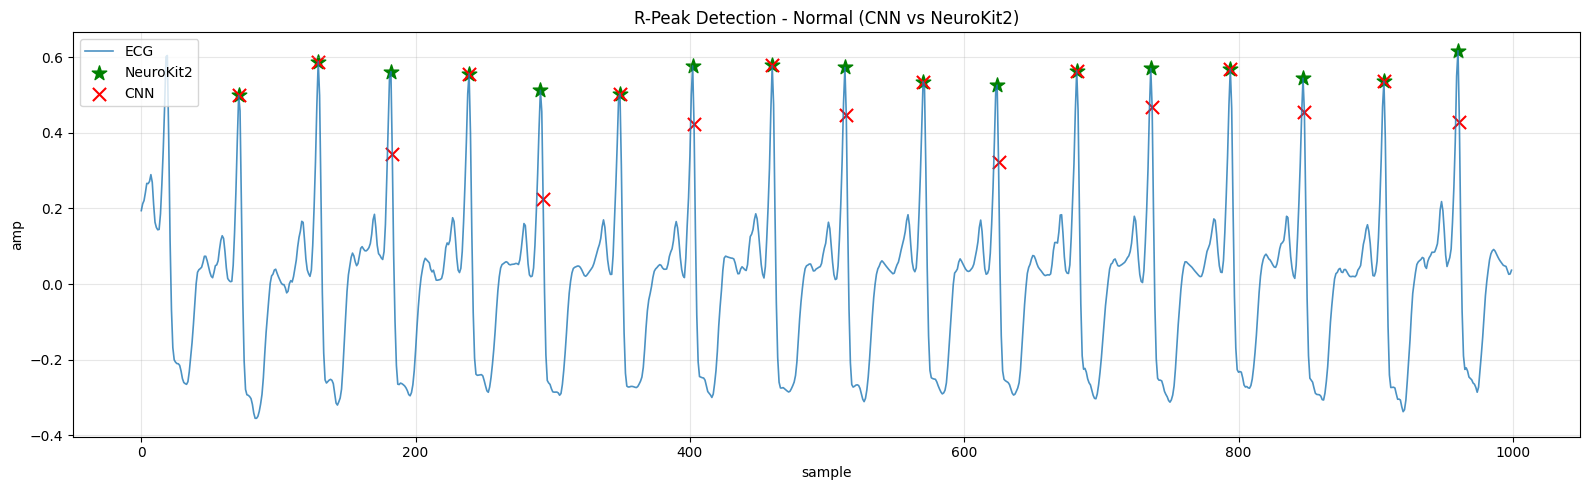

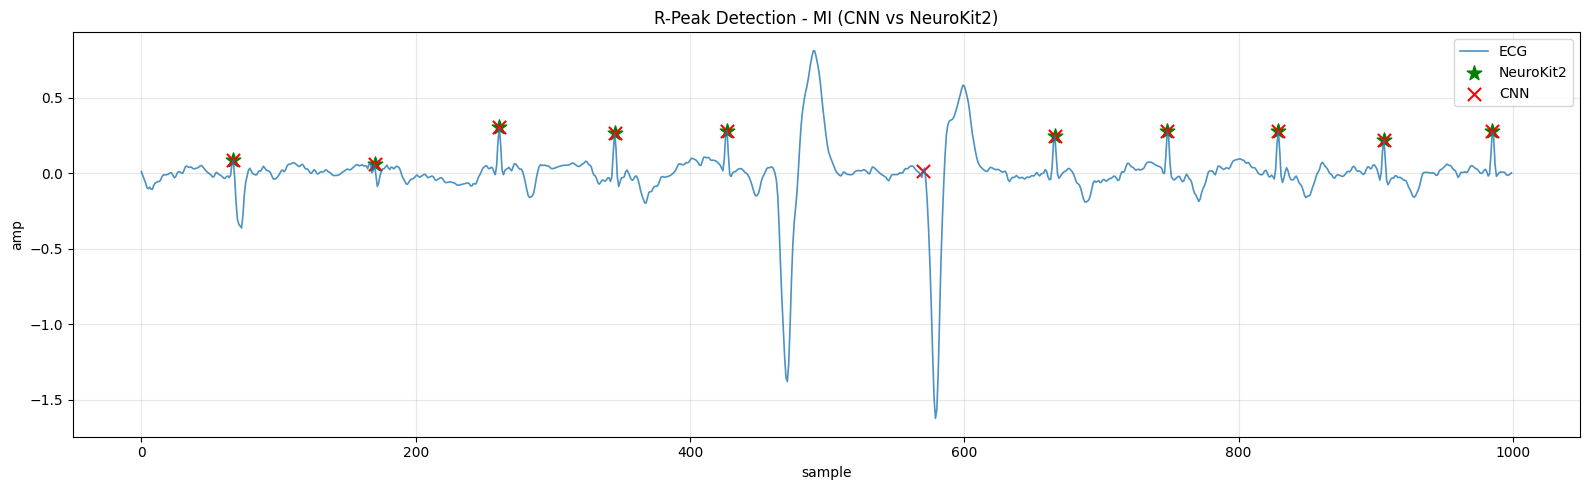

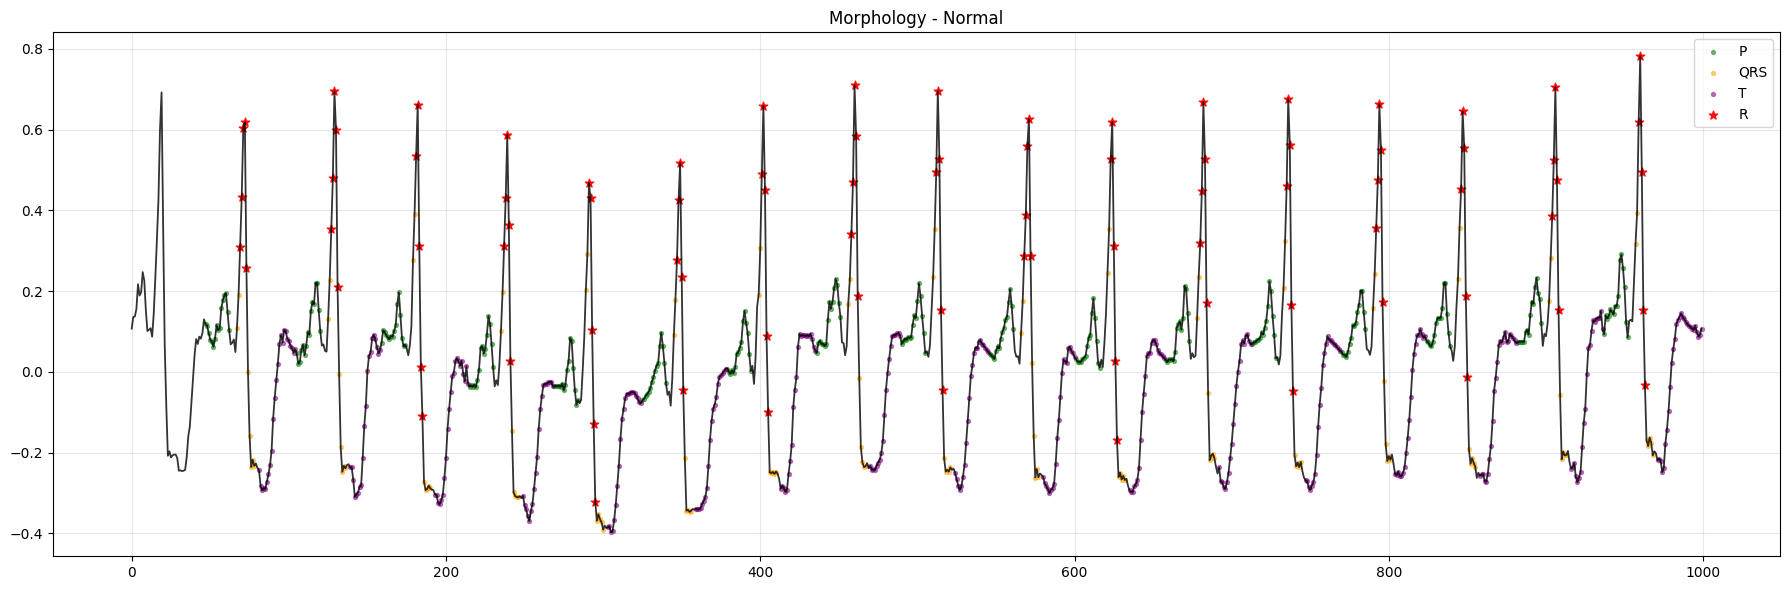

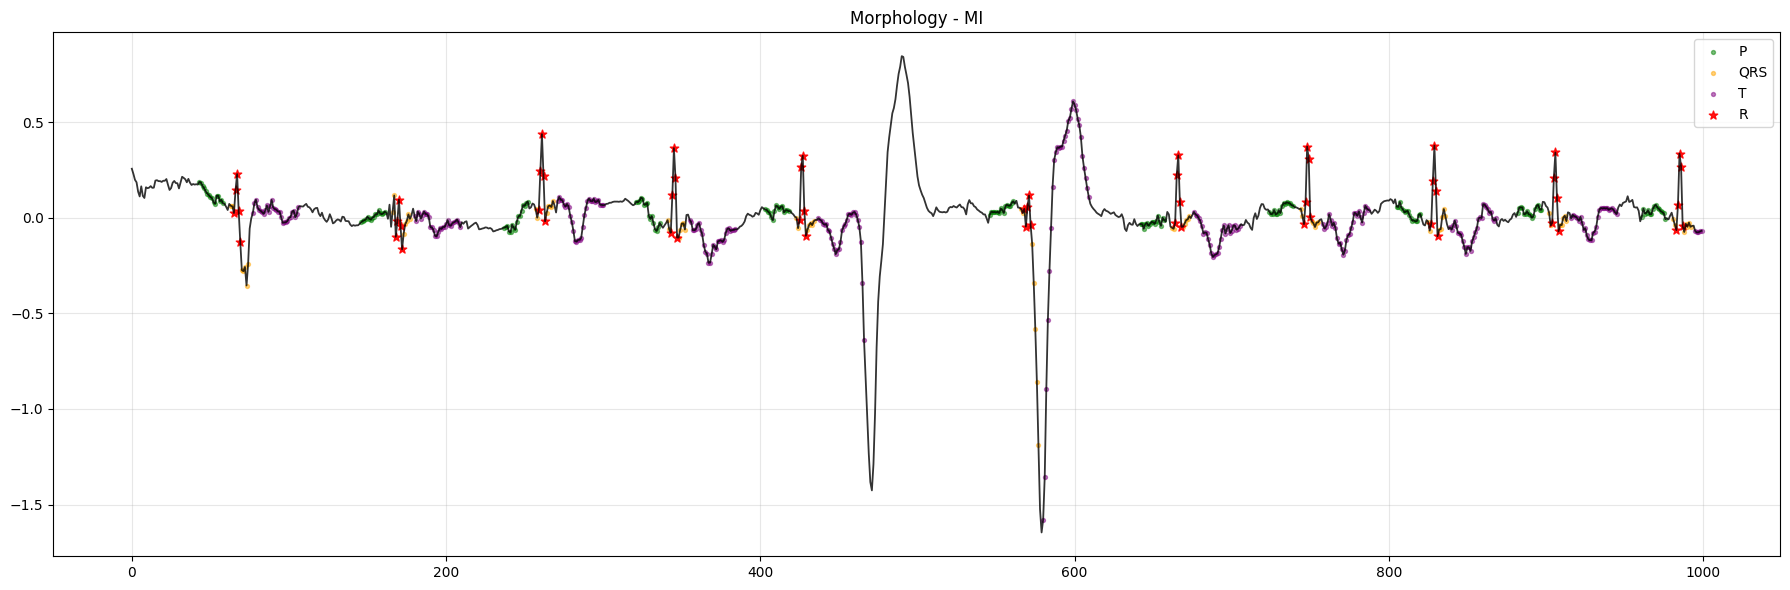

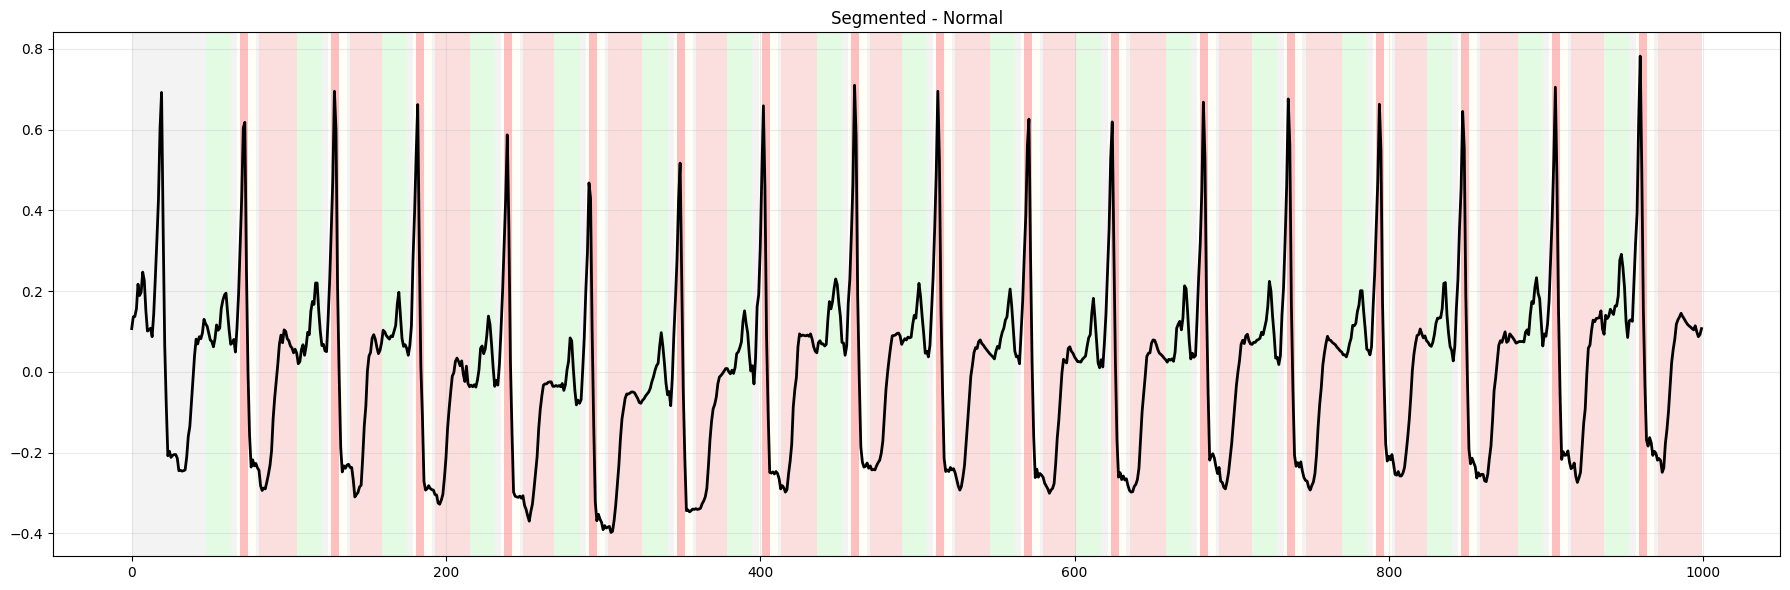

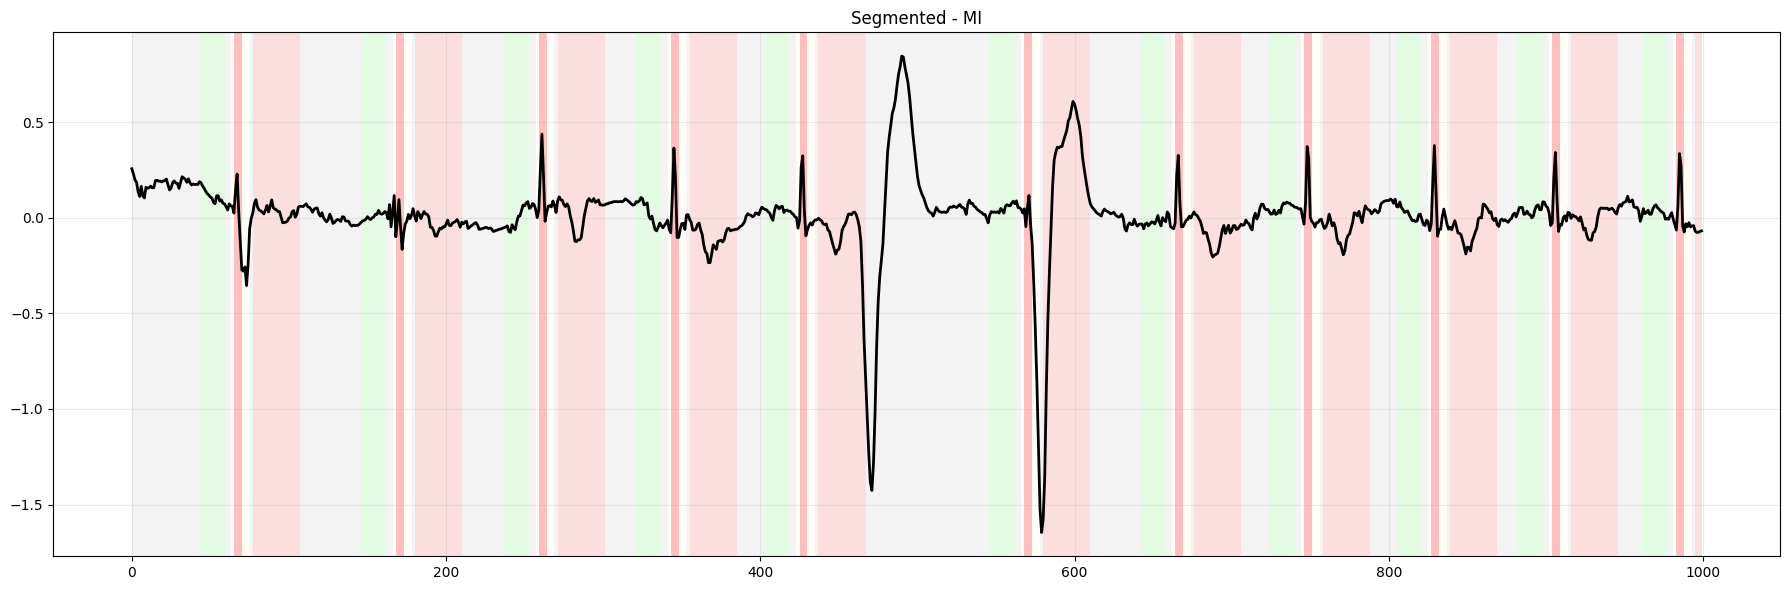

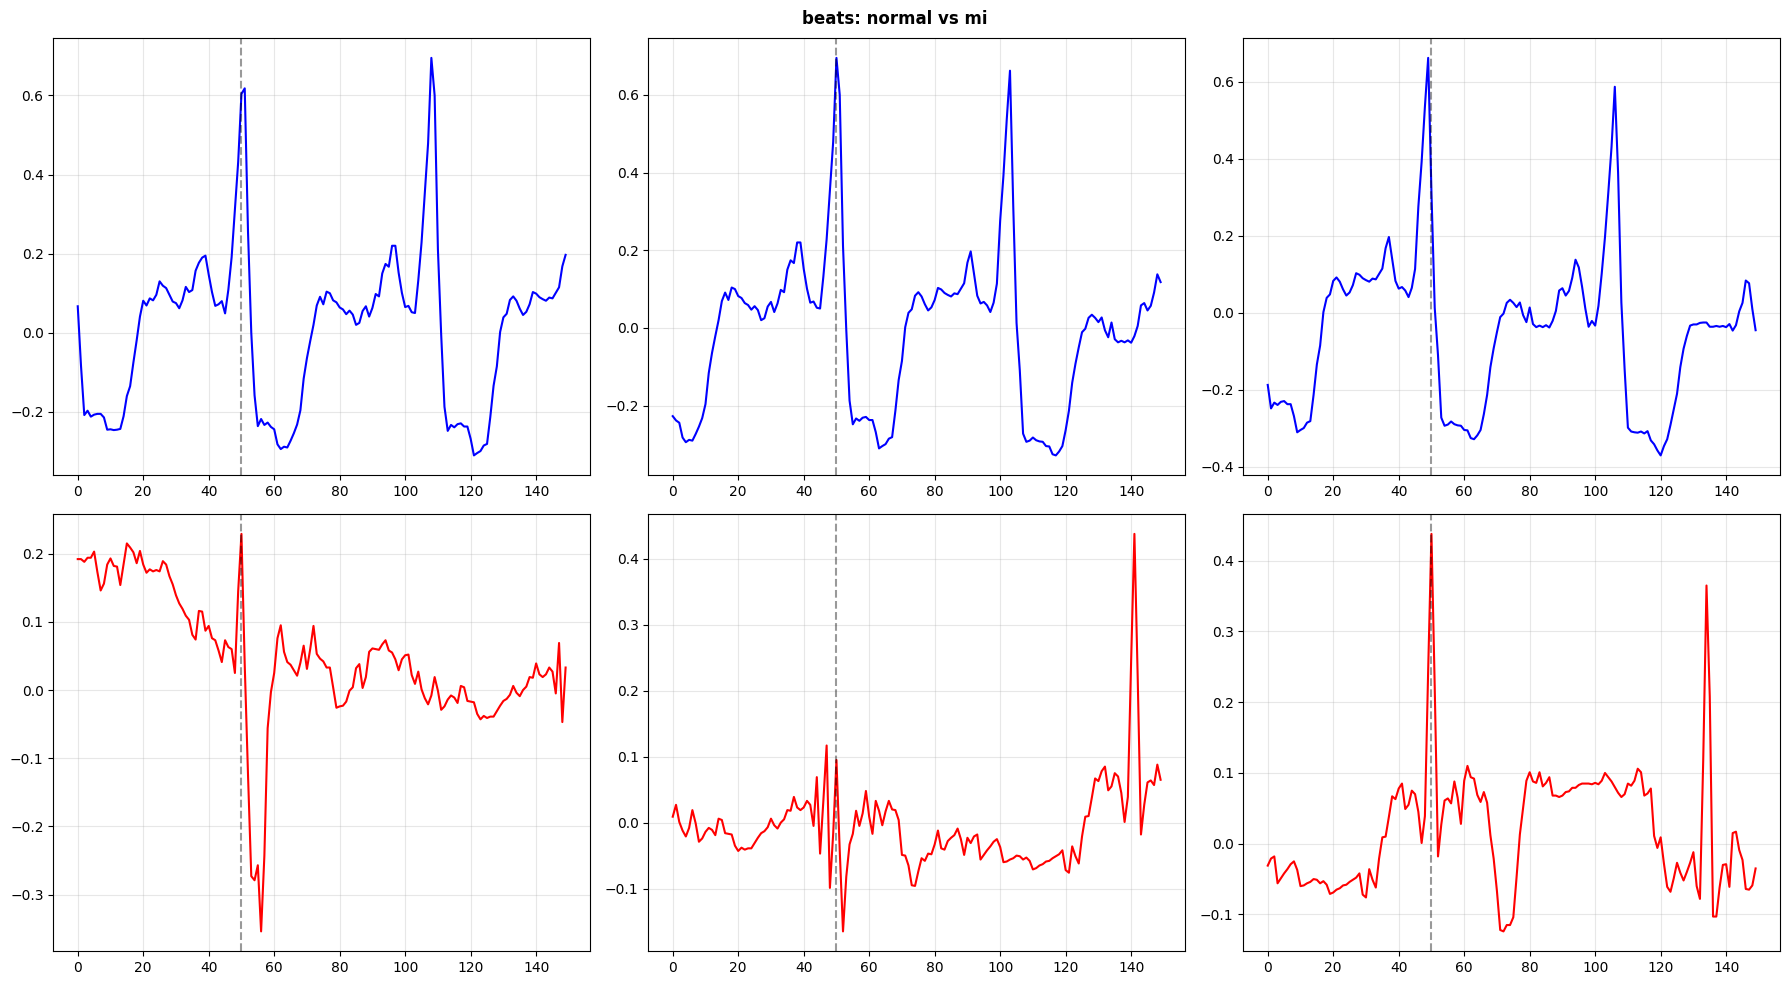

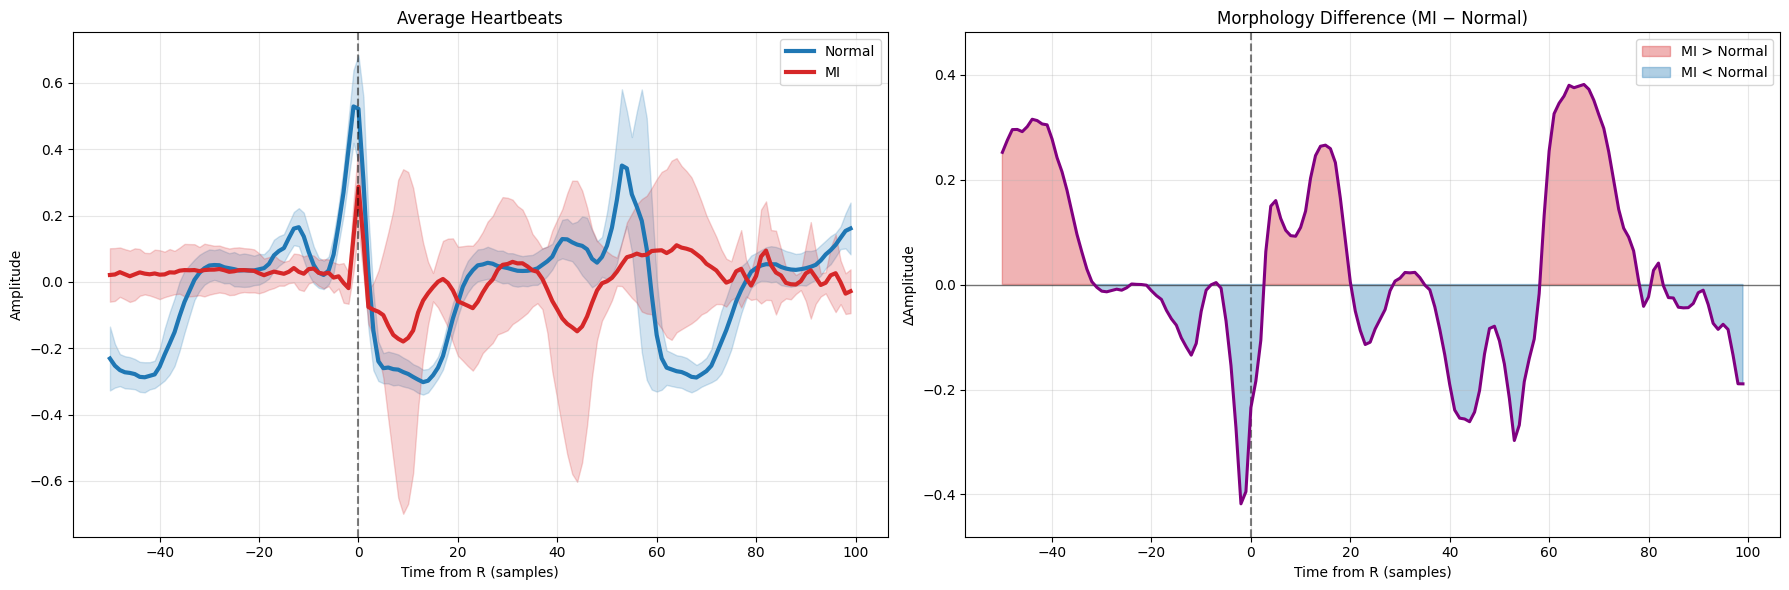

In [ ]:
# here, we load saved model rpeak_cnn.h5 and make plots on random PTB-XL samples
import os, ast
import numpy as np
import pandas as pd
import wfdb
import neurokit2 as nk
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def dice(y_true, y_pred, eps=1e-6):
    yt = tf.reshape(y_true, [-1]); yp = tf.reshape(y_pred, [-1])
    inter = tf.reduce_sum(yt * yp)
    return (2.*inter + eps) / (tf.reduce_sum(yt) + tf.reduce_sum(yp) + eps)

def pick_peaks_from_mask(mask, thr=0.5, min_dist=50):
    b = (mask > thr).astype(int).flatten()
    peaks, i = [], 0
    while i < len(b):
        if b[i] == 1:
            s = i
            while i < len(b) and b[i] == 1: i += 1
            e = i
            peaks.append((s+e)//2)
            i = e + min_dist
        else:
            i += 1
    return np.array(peaks)

def annotate_waves(sig, r_idx, fs=100):
    if sig.ndim > 1: sig = sig[:, 1]
    lab = np.zeros(len(sig))
    try:
        clean = nk.ecg_clean(sig, sampling_rate=fs)
        _, w = nk.ecg_delineate(clean, r_idx, sampling_rate=fs, method='dwt')
        if w.get('ECG_P_Peaks') is not None:
            p = w['ECG_P_Peaks']; p = p[~np.isnan(p)].astype(int)
            for k in p:
                a = max(0, k - int(0.04*fs)); b = min(len(sig), k + int(0.04*fs)); lab[a:b] = 1
        if w.get('ECG_R_Onsets') is not None and w.get('ECG_R_Offsets') is not None:
            q = w['ECG_R_Onsets']; s = w['ECG_R_Offsets']
            q = q[~np.isnan(q)].astype(int); s = s[~np.isnan(s)].astype(int)
            for a, b in zip(q, s):
                if 0 <= a < len(sig) and 0 <= b < len(sig): lab[a:b] = 2
        if w.get('ECG_T_Peaks') is not None:
            t = w['ECG_T_Peaks']; t = t[~np.isnan(t)].astype(int)
            for k in t:
                a = max(0, k - int(0.06*fs)); b = min(len(sig), k + int(0.06*fs)); lab[a:b] = 3
        for r in r_idx:
            a = max(0, r - 2); b = min(len(sig), r + 3); lab[a:b] = 4
    except:
        # simple fallback
        for r in r_idx:
            p1 = max(0, r - int(0.24*fs)); p2 = max(0, r - int(0.08*fs)); lab[p1:p2] = 1
            q1 = max(0, r - int(0.04*fs)); q2 = min(len(sig), r + int(0.08*fs)); lab[q1:q2] = 2
            t1 = min(len(sig), r + int(0.10*fs)); t2 = min(len(sig), r + int(0.40*fs)); lab[t1:t2] = 3
            a = max(0, r - 2); b = min(len(sig), r + 3); lab[a:b] = 4
    return lab

# plotting
def plot_rpeak_detection(sig, cnn_peaks, nk_peaks, title):
    plt.figure(figsize=(16,5))
    plt.plot(sig, lw=1.2, alpha=0.8, label='ECG')
    if len(nk_peaks):  plt.scatter(nk_peaks,  sig[nk_peaks],  s=120, c='g', marker='*', label='NeuroKit2')
    if len(cnn_peaks): plt.scatter(cnn_peaks, sig[cnn_peaks], s=90,  c='r', marker='x', label='CNN')
    plt.title(title); plt.xlabel('sample'); plt.ylabel('amp'); plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()

def plot_wave_annotation(sig, waves, peaks, title):
    fig, ax = plt.subplots(figsize=(18,6))
    ax.plot(sig, color='k', lw=1.3, alpha=0.8)
    colors = {1:'green', 2:'orange', 3:'purple', 4:'red'}
    names  = {1:'P',     2:'QRS',    3:'T',      4:'R'}
    for w in [1,2,3,4]:
        idx = np.where(waves==w)[0]
        if len(idx):
            ax.scatter(idx, sig[idx], s=(40 if w==4 else 8),
                       c=colors[w], marker=('*' if w==4 else 'o'),
                       alpha=(0.9 if w==4 else 0.5), label=names[w])
    ax.set_title(title); ax.legend(); ax.grid(alpha=0.3); plt.tight_layout()

def plot_segmented_ecg_regions(sig, waves, peaks, title):
    fig, ax = plt.subplots(figsize=(18,6))
    shades = ['lightgray','lightgreen','lightyellow','lightcoral','red']
    for i in range(len(sig)-1):
        ax.axvspan(i, i+1, facecolor=shades[int(waves[i])], alpha=0.25)
    ax.plot(sig, color='black', lw=2)
    ax.set_title(title); ax.grid(alpha=0.25); plt.tight_layout()

def plot_heartbeat_comparison(norm_sig, mi_sig, norm_peaks, mi_peaks):
    fig, axs = plt.subplots(2,3, figsize=(18,10)); fig.suptitle('beats: normal vs mi', fontweight='bold')
    before, after = 50, 100
    def beats(sig, r, n=3):
        out=[]
        for pk in r[:n]:
            if pk>before and pk<len(sig)-after: out.append(sig[pk-before:pk+after])
        return out
    bn, bm = beats(norm_sig, norm_peaks), beats(mi_sig, mi_peaks)
    for i in range(3):
        if i<len(bn): axs[0,i].plot(bn[i], 'b'); axs[0,i].axvline(before, ls='--', c='k', alpha=0.4)
        if i<len(bm): axs[1,i].plot(bm[i], 'r'); axs[1,i].axvline(before, ls='--', c='k', alpha=0.4)
        axs[0,i].grid(alpha=0.3); axs[1,i].grid(alpha=0.3)
    plt.tight_layout()

def plot_average_morphology(norm_sig, mi_sig, norm_peaks, mi_peaks, before=50, after=100):
    # collect fixed length beats around R
    def _avg(sig, r):
        beats = []
        for k in r:
            if k > before and k < len(sig) - after:
                beats.append(sig[k-before:k+after])
        if not beats:
            return None, None
        B = np.stack(beats).astype(float)
        return B.mean(0), B.std(0)

    n_avg, n_std = _avg(norm_sig, norm_peaks)
    m_avg, m_std = _avg(mi_sig,   mi_peaks)
    if n_avg is None or m_avg is None:
        print("not enough beats");
        return

    # time axis
    t = np.arange(-before, after)

    fig, ax = plt.subplots(1, 2, figsize=(18, 6))

    # (left) average beats with bands
    ax[0].plot(t, n_avg, color='tab:blue', lw=3, label='Normal')
    ax[0].fill_between(t, n_avg - n_std, n_avg + n_std, color='tab:blue', alpha=0.2)
    ax[0].plot(t, m_avg, color='tab:red', lw=3, label='MI')
    ax[0].fill_between(t, m_avg - m_std, m_avg + m_std, color='tab:red', alpha=0.2)
    ax[0].axvline(0, ls='--', c='k', alpha=0.5)
    ax[0].grid(alpha=0.3); ax[0].legend()
    ax[0].set_title('Average Heartbeats');
    ax[0].set_xlabel('Time from R (samples)'); ax[0].set_ylabel('Amplitude')

    # (right) MI - Normal with CLEAR color shading
    diff = m_avg - n_avg
    ax[1].axhline(0, c='k', lw=1, alpha=0.5)
    ax[1].axvline(0, ls='--', c='k', alpha=0.5)

    # red where MI > Normal, blue where MI < Normal
    ax[1].fill_between(t, 0, diff, where=(diff >= 0), interpolate=True,
                       color='tab:red', alpha=0.35, label='MI > Normal')
    ax[1].fill_between(t, 0, diff, where=(diff < 0), interpolate=True,
                       color='tab:blue', alpha=0.35, label='MI < Normal')

    ax[1].plot(t, diff, color='purple', lw=2.2)
    # nice symmetric y-lims
    ylim = np.nanmax(np.abs(diff)) * 1.15
    if np.isfinite(ylim) and ylim > 0:
        ax[1].set_ylim(-ylim, ylim)

    ax[1].grid(alpha=0.3); ax[1].legend()
    ax[1].set_title('Morphology Difference (MI − Normal)')
    ax[1].set_xlabel('Time from R (samples)'); ax[1].set_ylabel('ΔAmplitude')

    plt.tight_layout()

#very small PTB-XL loader
class ECGLoader:
    def __init__(self):
        base = '/kaggle/input/ptb-xl-dataset/'
        self.root = None
        for d in os.listdir(base):
            p = os.path.join(base, d)
            if os.path.isdir(p) and os.path.exists(os.path.join(p, 'ptbxl_database.csv')):
                self.root = p + '/'
                break
        if self.root is None: raise FileNotFoundError("PTB-XL path not found")
    def _csv(self):
        df = pd.read_csv(os.path.join(self.root, 'ptbxl_database.csv'), index_col='ecg_id')
        df.scp_codes = df.scp_codes.apply(lambda x: ast.literal_eval(x))
        return df
    def split_norm_mi(self):
        df = self._csv()
        mi_tags = ['IMI','AMI','ASMI','ILMI','IPLMI','IPMI','PMI','LMI','ALMI','INJAS','INJAL','INJIL','INJIN','INJLA']
        norm = df[df.scp_codes.apply(lambda x: 'NORM' in x)]
        mi   = df[df.scp_codes.apply(lambda x: any(t in x for t in mi_tags))]
        return norm, mi
    def read_ecg(self, relpath):
        return wfdb.rdsamp(os.path.join(self.root, relpath))[0]

# load model
fs = 100
MODEL_PATH = "rpeak_cnn.h5"
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"missing model: {MODEL_PATH}")
model = keras.models.load_model(MODEL_PATH, custom_objects={'dice': dice}, compile=False)
print("model loaded")

# random normal and MI sample selection
ldr = ECGLoader()
df_norm, df_mi = ldr.split_norm_mi()
row_norm = df_norm.sample(1).iloc[0]
row_mi   = df_mi.sample(1).iloc[0]

ecg_norm = ldr.read_ecg(row_norm["filename_lr"])
ecg_mi   = ldr.read_ecg(row_mi["filename_lr"])
sig_norm = ecg_norm[:, 1]
sig_mi   = ecg_mi[:, 1]

# clean, reference peaks
sig_norm_clean = nk.ecg_clean(sig_norm, sampling_rate=fs)
sig_mi_clean   = nk.ecg_clean(sig_mi,   sampling_rate=fs)
_, nk_norm = nk.ecg_peaks(sig_norm_clean, sampling_rate=fs, method="neurokit")
_, nk_mi   = nk.ecg_peaks(sig_mi_clean,   sampling_rate=fs, method="neurokit")
nk_peaks_norm = nk_norm["ECG_R_Peaks"]
nk_peaks_mi   = nk_mi["ECG_R_Peaks"]

# predict mask r peaks
pred_norm = model.predict(sig_norm_clean.reshape(1, -1, 1), verbose=0)[0]
pred_mi   = model.predict(sig_mi_clean.reshape(1, -1, 1),   verbose=0)[0]
cnn_peaks_norm = pick_peaks_from_mask(pred_norm, thr=0.5, min_dist=50)
cnn_peaks_mi   = pick_peaks_from_mask(pred_mi,   thr=0.5, min_dist=50)

print("normal:", row_norm["filename_lr"], "| nk:", len(nk_peaks_norm), "cnn:", len(cnn_peaks_norm))
print("mi    :", row_mi["filename_lr"],   "| nk:", len(nk_peaks_mi),   "cnn:", len(cnn_peaks_mi))

# labels from CNN peaks
waves_norm = annotate_waves(sig_norm, cnn_peaks_norm, fs=fs)
waves_mi   = annotate_waves(sig_mi,   cnn_peaks_mi,   fs=fs)

# make figures (saved with .png)
plot_rpeak_detection(sig_norm_clean, cnn_peaks_norm, nk_peaks_norm, "R-Peak Detection - Normal (CNN vs NeuroKit2)")
plt.savefig("/kaggle/working/rpeak_normal_rand.png", dpi=150, bbox_inches="tight"); plt.show()

plot_rpeak_detection(sig_mi_clean, cnn_peaks_mi, nk_peaks_mi, "R-Peak Detection - MI (CNN vs NeuroKit2)")
plt.savefig("/kaggle/working/rpeak_mi_rand.png",     dpi=150, bbox_inches="tight"); plt.show()

plot_wave_annotation(sig_norm, waves_norm, cnn_peaks_norm, "Morphology - Normal")
plt.savefig("/kaggle/working/annotation_normal_rand.png", dpi=150, bbox_inches="tight"); plt.show()

plot_wave_annotation(sig_mi, waves_mi, cnn_peaks_mi, "Morphology - MI")
plt.savefig("/kaggle/working/annotation_mi_rand.png", dpi=150, bbox_inches="tight"); plt.show()

plot_segmented_ecg_regions(sig_norm, waves_norm, cnn_peaks_norm, "Segmented - Normal")
plt.savefig("/kaggle/working/segmented_normal_rand.png", dpi=150, bbox_inches="tight"); plt.show()

plot_segmented_ecg_regions(sig_mi, waves_mi, cnn_peaks_mi, "Segmented - MI")
plt.savefig("/kaggle/working/q2_segmented_mi_rand.png", dpi=150, bbox_inches="tight"); plt.show()

plot_heartbeat_comparison(sig_norm, sig_mi, cnn_peaks_norm, cnn_peaks_mi)
plt.savefig("/kaggle/working/heartbeat_comparison_rand.png", dpi=150, bbox_inches="tight"); plt.show()

plot_average_morphology(sig_norm, sig_mi, cnn_peaks_norm, cnn_peaks_mi)
plt.savefig("/kaggle/working/average_morphology_rand.png", dpi=150, bbox_inches="tight"); plt.show()
